In [17]:
from dataset.cldataset import CLDataset
from dataset.cifar10 import CIFAR10Dataset
from torch.utils.data import DataLoader
import tqdm
from models.clip_model import CLIPModel

import random
import numpy as np

/home/hamt/cll_vlm/cll_vlm/vlm/CLIP


In [6]:
class MockConfig:
    def __init__(self):
        self.debug = True

# Example usage
cfg = MockConfig()  # Replace with actual config object

train_dataset = CIFAR10Dataset(
    root='/home/hamt/cll_vlm/cll_vlm/data/cifar10',
    train=True,
    transform=None  # No transform for visualization
)
train_dataset.cfg = cfg
original_dataset, shuffled_dataset = train_dataset.get_shuffled_labels_dataset()
print(f"Original dataset size: {len(original_dataset)}")
print(f"Shuffled dataset size: {len(shuffled_dataset)}")

import matplotlib.pyplot as plt

# Function to display images side by side
def show_comparison(idx):
    orig_img, orig_label = original_dataset[idx]
    shuf_img, shuf_label = shuffled_dataset[idx]
    
    orig_class = original_dataset.classes[orig_label]
    shuf_class = shuffled_dataset.classes[shuf_label]
    
    # Create side-by-side plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Display original image
    ax1.imshow(orig_img)
    ax1.set_title(f'Original\nLabel: {orig_label} ({orig_class})', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Display shuffled image (same image, different label)
    ax2.imshow(shuf_img)
    ax2.set_title(f'Shuffled\nLabel: {shuf_label} ({shuf_class})', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    
    # Check if images are identical
    images_identical = np.array_equal(np.array(orig_img), np.array(shuf_img))
    labels_different = orig_label != shuf_label
    
    plt.tight_layout()
    plt.show()
    
    # Print verification
    print(f"✓ Images identical: {images_identical}")
    print(f"✓ Labels different: {labels_different}")
    print(f"Original: {orig_class} (label {orig_label}) → Shuffled: {shuf_class} (label {shuf_label})")
    print("-" * 60)

# # Show 5 random samples iteratively
# print("\n🔍 Showing Original vs Shuffled Image Comparisons:")
# print("=" * 60)

# for i in range(3):
#     idx = random.randint(0, len(original_dataset) - 1)
#     print(f"\nComparison {i+1}:")
#     show_comparison(idx)

### Test CLIP

In [18]:
import os
import sys
import torch
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

ROOT_PATH = "/home/hamt/cll_vlm/cll_vlm"
CLIP_PATH = os.path.join(ROOT_PATH, "vlm/CLIP")
sys.path.append(CLIP_PATH)
import clip

model = CLIPModel("ViT-B/32", device="cuda")

# Test tren toan bo dataset

In [11]:
def pil_collate(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

class MockConfig:
    def __init__(self):
        self.debug = True

# Example usage
cfg = MockConfig()  # Replace with actual config object

train_dataset = CIFAR10Dataset(
    root='/home/hamt/cll_vlm/cll_vlm/data/cifar10',
    train=True,
    transform=None  # No transform for visualization
)
train_dataset.cfg = cfg
original_dataset, shuffled_dataset = train_dataset.get_shuffled_labels_dataset()
print(f"Original dataset size: {len(original_dataset)}")
print(f"Shuffled dataset size: {len(shuffled_dataset)}")

Created shuffled dataset:
  - Original dataset: 50000 samples
  - Shuffled dataset: 50000 samples
  - Labels shuffled: True
Original dataset size: 50000
Shuffled dataset size: 50000


In [ ]:
from tqdm.auto import tqdm

threshold = 0.24
batch_size = 256

loader = DataLoader(
    shuffled_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pil_collate
)

scores, preds, gts, pred_cls = [], [], [], []

for idx, (images, shuf_labels) in enumerate(tqdm(loader, desc="Evaluating")):
    # Lấy original labels (cùng index)
    orig_batch = [original_dataset[i + idx*batch_size] for i in range(len(shuf_labels))]
    _, orig_labels = zip(*orig_batch)
    orig_labels = torch.tensor(orig_labels)

    # Prompt từ shuffled labels
    prompts = [f"a photo of a {shuffled_dataset.classes[l]}" for l in shuf_labels]

    # Encode
    img_feats = model.encode_image(images)
    txt_feats = model.encode_text(prompts)

    # Similarity
    sims = model.similarity(img_feats, txt_feats)
    diag_scores = sims.diag().cpu().numpy().tolist()

    # Ground truth: OL = 1, CL = 0
    gts.extend([(1 if s == o else 0) for s, o in zip(shuf_labels, orig_labels)])

    # Predictions từ threshold
    preds.extend([1 if s >= threshold else 0 for s in diag_scores])

    # Save score
    scores.extend(diag_scores)

Evaluating: 100%|██████████| 196/196 [01:02<00:00,  3.14it/s]


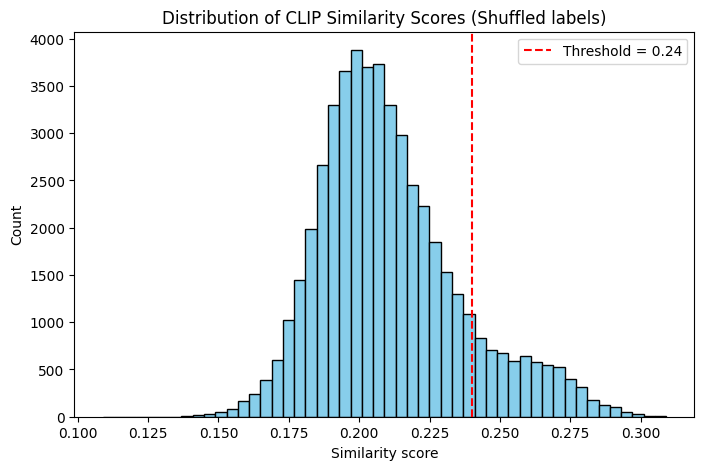

In [23]:
# Distribution plot
plt.figure(figsize=(8, 5))
plt.hist(scores, bins=50, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title("Distribution of CLIP Similarity Scores (Shuffled labels)")
plt.xlabel("Similarity score")
plt.ylabel("Count")
plt.legend()
plt.show()

Sample counts:
Same labels or Ordinary labels: 4923 samples
Different labels or Complementary labels: 45077 samples


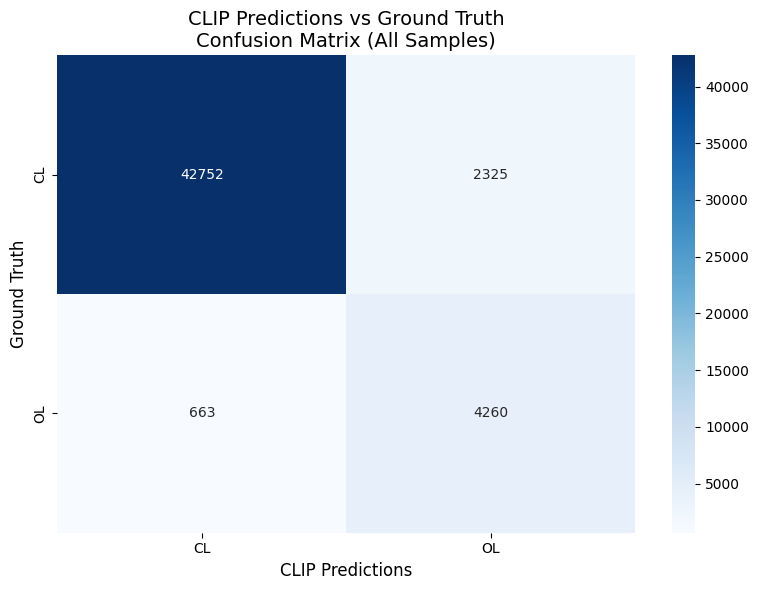


CONFUSION MATRIX ANALYSIS - ALL SAMPLES

Confusion Matrix Breakdown:
  True Negatives (correctly predicted CL labels): 42752
  False Positives (wrongly predicted OL labels): 2325
  False Negatives (wrongly predicted CL labels): 663
  True Positives (correctly predicted OL labels): 4260

Performance Metrics:
  Accuracy: 0.9402
  Precision: 0.6469
  Recall: 0.8653
  F1-Score: 0.7404


In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert lists to numpy arrays for proper masking operations
gts = np.array(gts)
preds = np.array(preds)
scores = np.array(scores)

# Create masks for same/different labels
same_label_mask = (gts == 1)  # Where original == shuffled
diff_label_mask = (gts == 0)  # Where original != shuffled

print("Sample counts:")
print(f"Same labels or Ordinary labels: {same_label_mask.sum()} samples")
print(f"Different labels or Complementary labels: {diff_label_mask.sum()} samples")

# Create confusion matrix for all predictions vs ground truth
cm_all = confusion_matrix(gts, preds)

# Plot single confusion matrix for all samples
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['CL', 'OL'], 
            yticklabels=['CL', 'OL'])
plt.title('CLIP Predictions vs Ground Truth\nConfusion Matrix (All Samples)', fontsize=14)
plt.xlabel('CLIP Predictions', fontsize=12)
plt.ylabel('Ground Truth', fontsize=12)
plt.tight_layout()
plt.show()

# Print detailed metrics for all samples
print("\n" + "="*60)
print("CONFUSION MATRIX ANALYSIS - ALL SAMPLES")
print("="*60)

if cm_all.shape == (2, 2):
    tn, fp, fn, tp = cm_all.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    print(f"\nConfusion Matrix Breakdown:")
    print(f"  True Negatives (correctly predicted CL labels): {tn}")
    print(f"  False Positives (wrongly predicted OL labels): {fp}")
    print(f"  False Negatives (wrongly predicted CL labels): {fn}")
    print(f"  True Positives (correctly predicted OL labels): {tp}")

    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
else:
    print("Unexpected confusion matrix shape:", cm_all.shape)

TOP 10% PREDICTIONS ANALYSIS
Top 10% threshold (90th percentile): 0.2477
Samples in top 10%: 5016 / 50000
Percentage: 10.03%


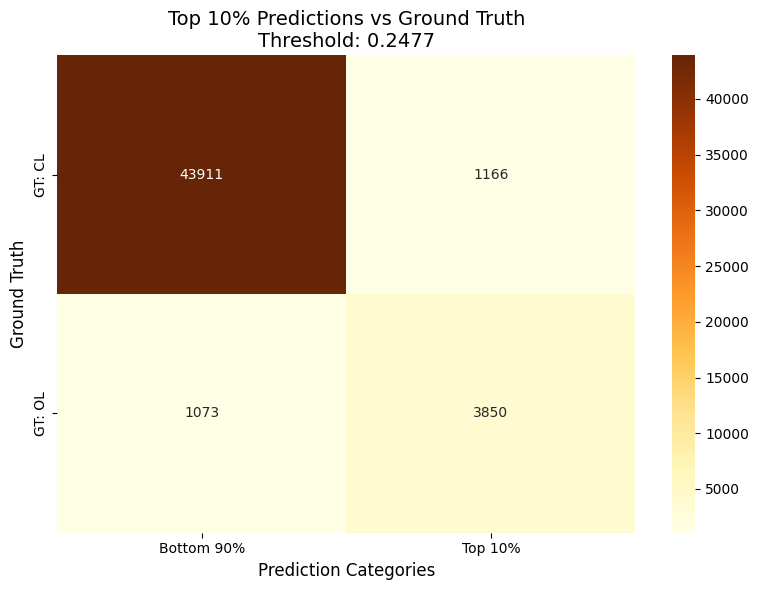


Top 10% Confusion Matrix Analysis:

Confusion Matrix Breakdown:
  True Negatives (CL correctly in bottom 90%): 43911
  False Positives (CL wrongly in top 10%): 1166
  False Negatives (OL wrongly in bottom 90%): 1073
  True Positives (OL correctly in top 10%): 3850

Performance Metrics:
  Accuracy: 0.9552
  Precision: 0.7675 (How many in top 10% are actually OL)
  Recall: 0.7820 (How many OL samples are captured in top 10%)
  F1-Score: 0.7747

Additional Insights:
  OL purity in top 10%: 0.7675 (76.8%)
  OL samples captured: 0.7820 (78.2%)
  Total OL samples: 4923
  Total CL samples: 45077

COMPARISON: TOP 10% vs ORIGINAL THRESHOLD
Original threshold (0.24): Accuracy = 0.9402
Top 10% method: Accuracy = 0.9552
Improvement: +1.50 percentage points


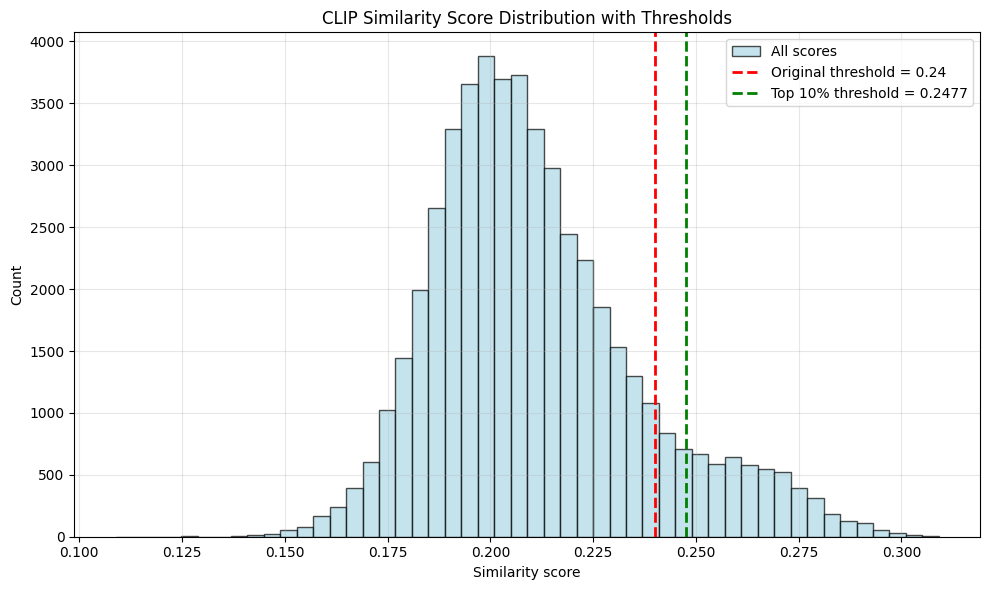

In [27]:
# Top 10% predictions analysis
print("="*60)
print("TOP 10% PREDICTIONS ANALYSIS")
print("="*60)

# Calculate the threshold for top 10% of similarity scores
top_10_percent_threshold = np.percentile(scores, 90)
print(f"Top 10% threshold (90th percentile): {top_10_percent_threshold:.4f}")

# Create new predictions based on top 10% rule
# Top 10% get label 1 (OL - Ordinary Labels), rest get label 0 (CL - Complementary Labels)
top_10_predictions = (scores >= top_10_percent_threshold).astype(int)

print(f"Samples in top 10%: {top_10_predictions.sum()} / {len(scores)}")
print(f"Percentage: {(top_10_predictions.sum() / len(scores)) * 100:.2f}%")

# Create confusion matrix with top 10% predictions
cm_top10 = confusion_matrix(gts, top_10_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_top10, annot=True, fmt='d', cmap='YlOrBr', 
            xticklabels=['Bottom 90%', 'Top 10%'], 
            yticklabels=['GT: CL', 'GT: OL'])
plt.title(f'Top 10% Predictions vs Ground Truth\nThreshold: {top_10_percent_threshold:.4f}', fontsize=14)
plt.xlabel('Prediction Categories', fontsize=12)
plt.ylabel('Ground Truth', fontsize=12)
plt.tight_layout()
plt.show()

# Print detailed metrics
print(f"\nTop 10% Confusion Matrix Analysis:")
print("="*40)

if cm_top10.shape == (2, 2):
    tn, fp, fn, tp = cm_top10.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    print(f"\nConfusion Matrix Breakdown:")
    print(f"  True Negatives (CL correctly in bottom 90%): {tn}")
    print(f"  False Positives (CL wrongly in top 10%): {fp}")
    print(f"  False Negatives (OL wrongly in bottom 90%): {fn}")
    print(f"  True Positives (OL correctly in top 10%): {tp}")
    
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f} (How many in top 10% are actually OL)")
    print(f"  Recall: {recall:.4f} (How many OL samples are captured in top 10%)")
    print(f"  F1-Score: {f1:.4f}")
    
    # Calculate additional insights
    ol_in_top10_rate = tp / (tp + fp) if (tp + fp) > 0 else 0
    ol_capture_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nAdditional Insights:")
    print(f"  OL purity in top 10%: {ol_in_top10_rate:.4f} ({ol_in_top10_rate*100:.1f}%)")
    print(f"  OL samples captured: {ol_capture_rate:.4f} ({ol_capture_rate*100:.1f}%)")
    print(f"  Total OL samples: {(tp + fn)}")
    print(f"  Total CL samples: {(tn + fp)}")

# Compare with original threshold-based predictions
print(f"\n" + "="*60)
print("COMPARISON: TOP 10% vs ORIGINAL THRESHOLD")
print("="*60)

original_accuracy = (preds == gts).sum() / len(scores)
top10_accuracy = accuracy

print(f"Original threshold ({threshold}): Accuracy = {original_accuracy:.4f}")
print(f"Top 10% method: Accuracy = {top10_accuracy:.4f}")
print(f"Improvement: {((top10_accuracy - original_accuracy) * 100):+.2f} percentage points")

# Show score distribution with both thresholds
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='lightblue', alpha=0.7, edgecolor='black', label='All scores')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Original threshold = {threshold}')
plt.axvline(top_10_percent_threshold, color='green', linestyle='--', linewidth=2, label=f'Top 10% threshold = {top_10_percent_threshold:.4f}')
plt.title("CLIP Similarity Score Distribution with Thresholds")
plt.xlabel("Similarity score")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

CLASS DISTRIBUTION ANALYSIS & PER-CLASS ACCURACY
Total samples: 50000
Predictions available for: 50000 samples
CL samples: 43415
OL samples: 6585
Total samples: 50000
Predictions available for: 50000 samples
CL samples: 43415
OL samples: 6585


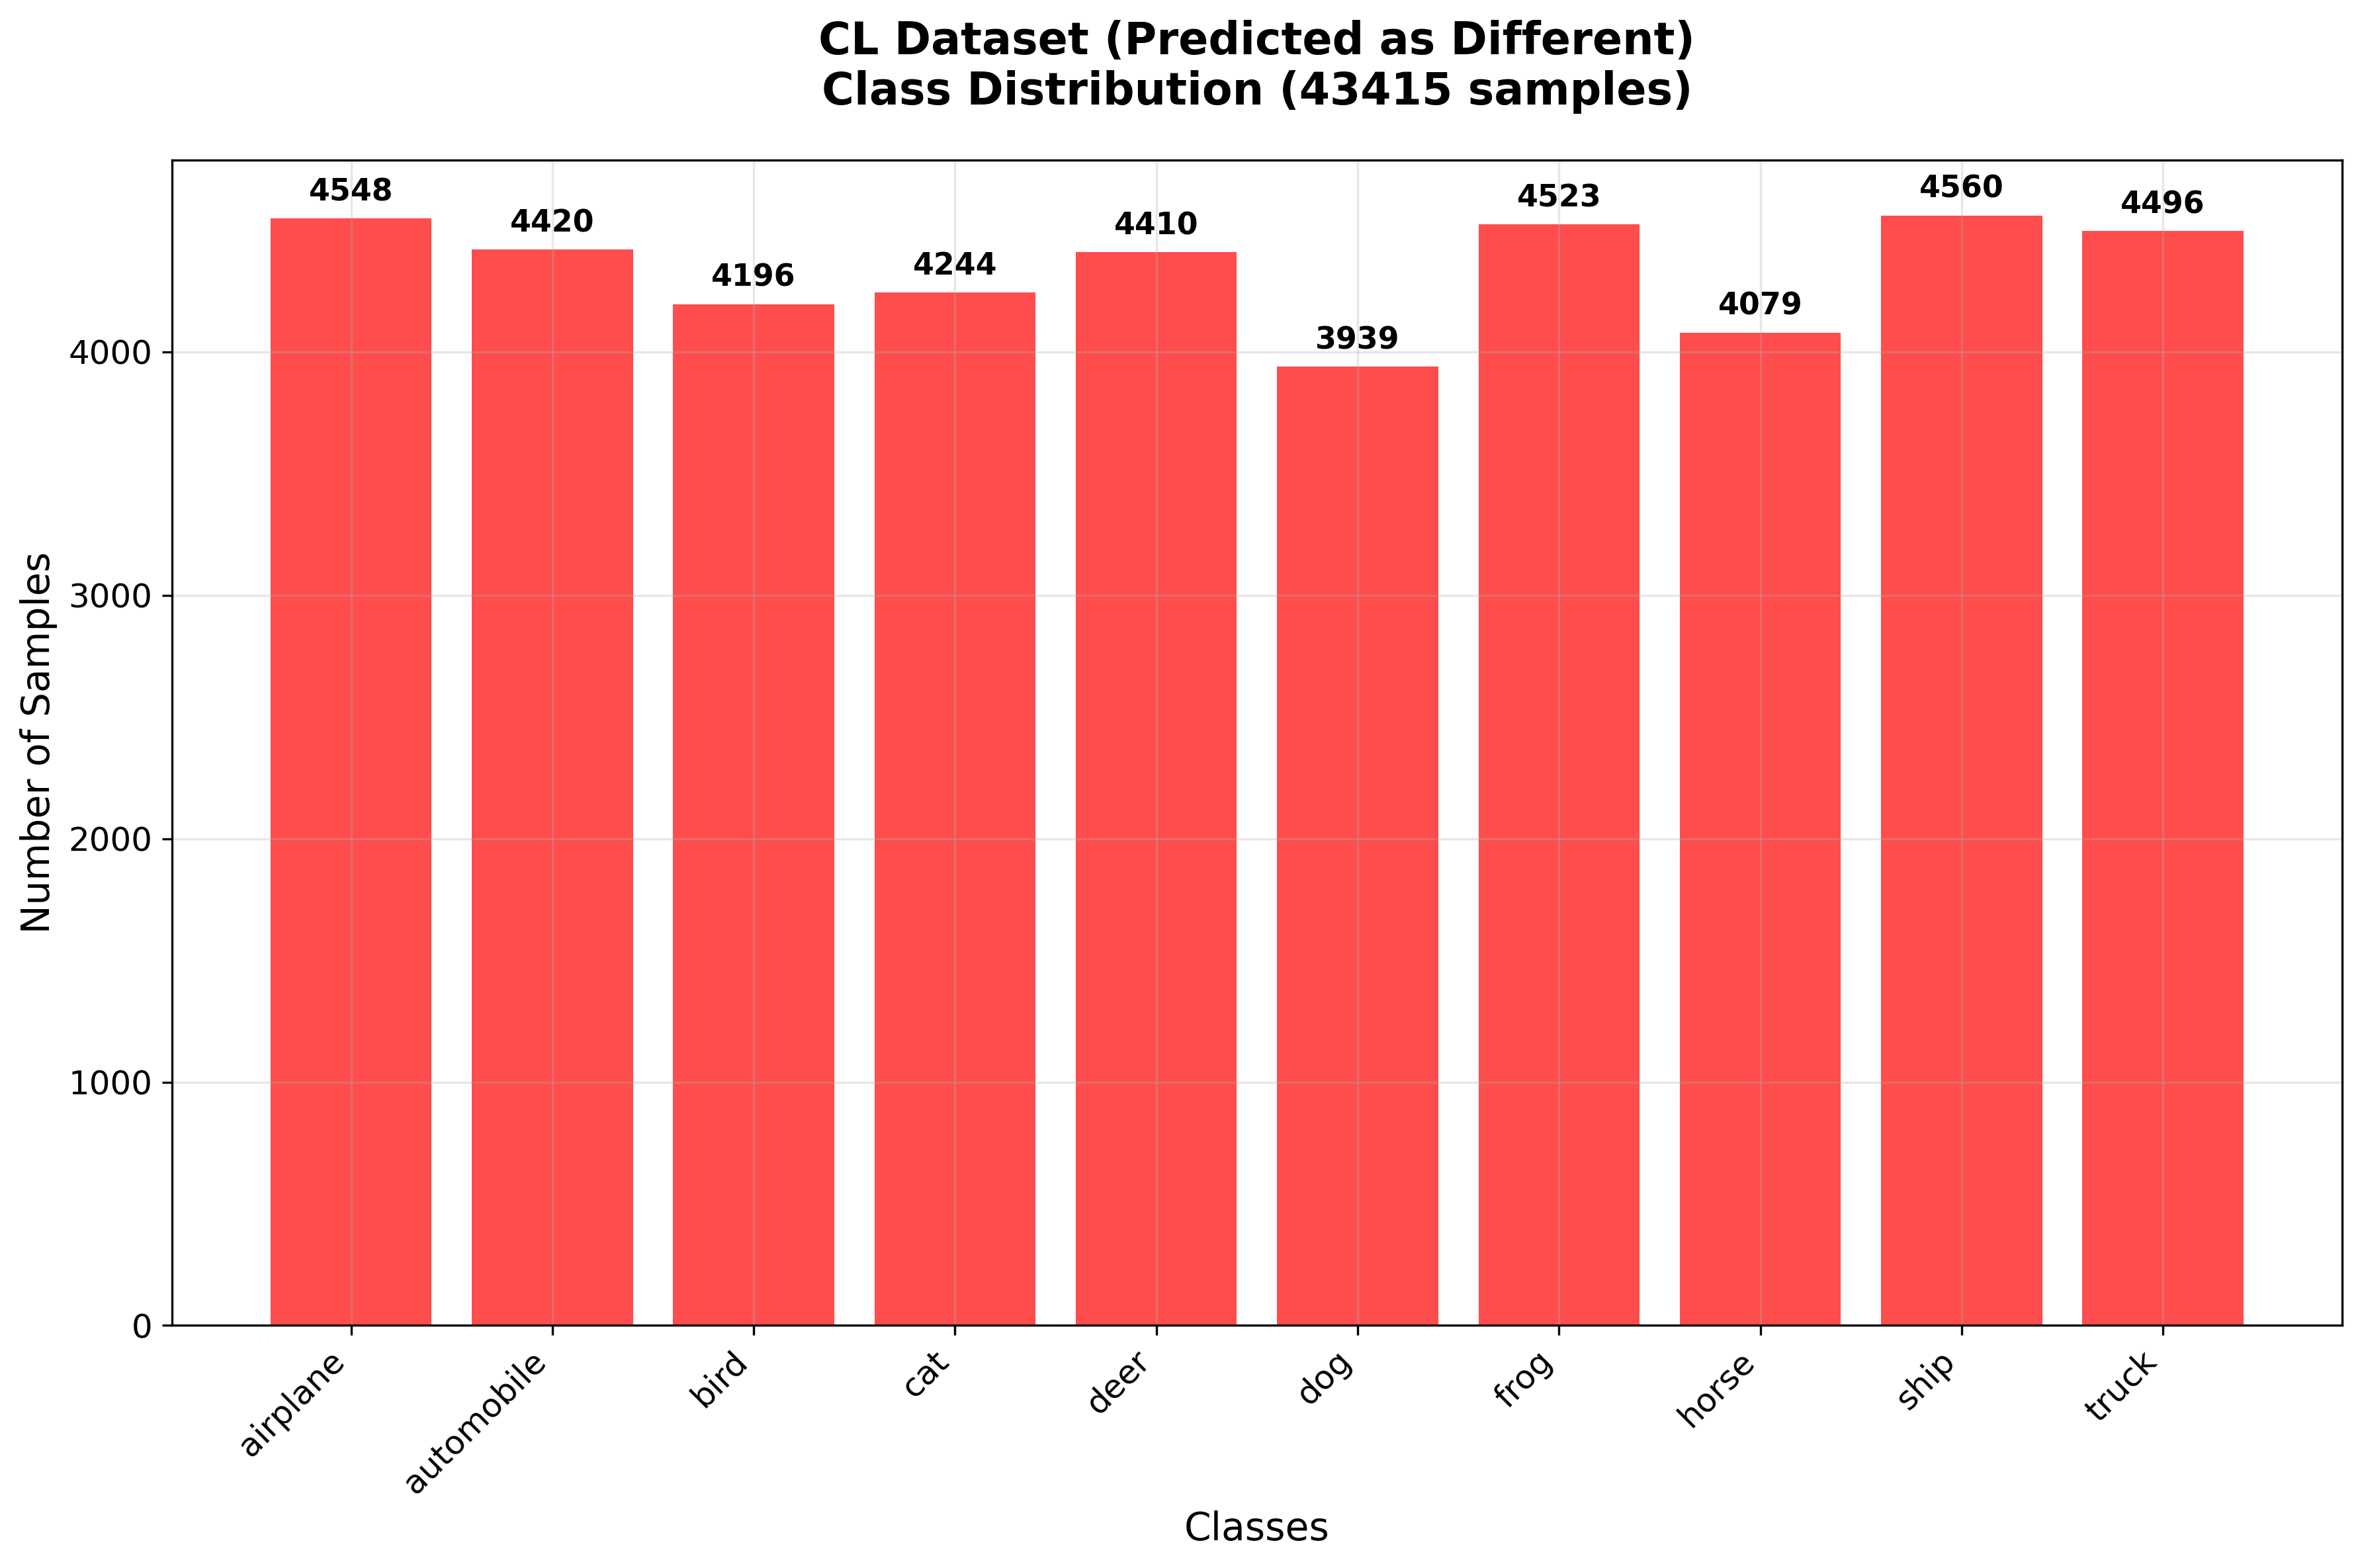

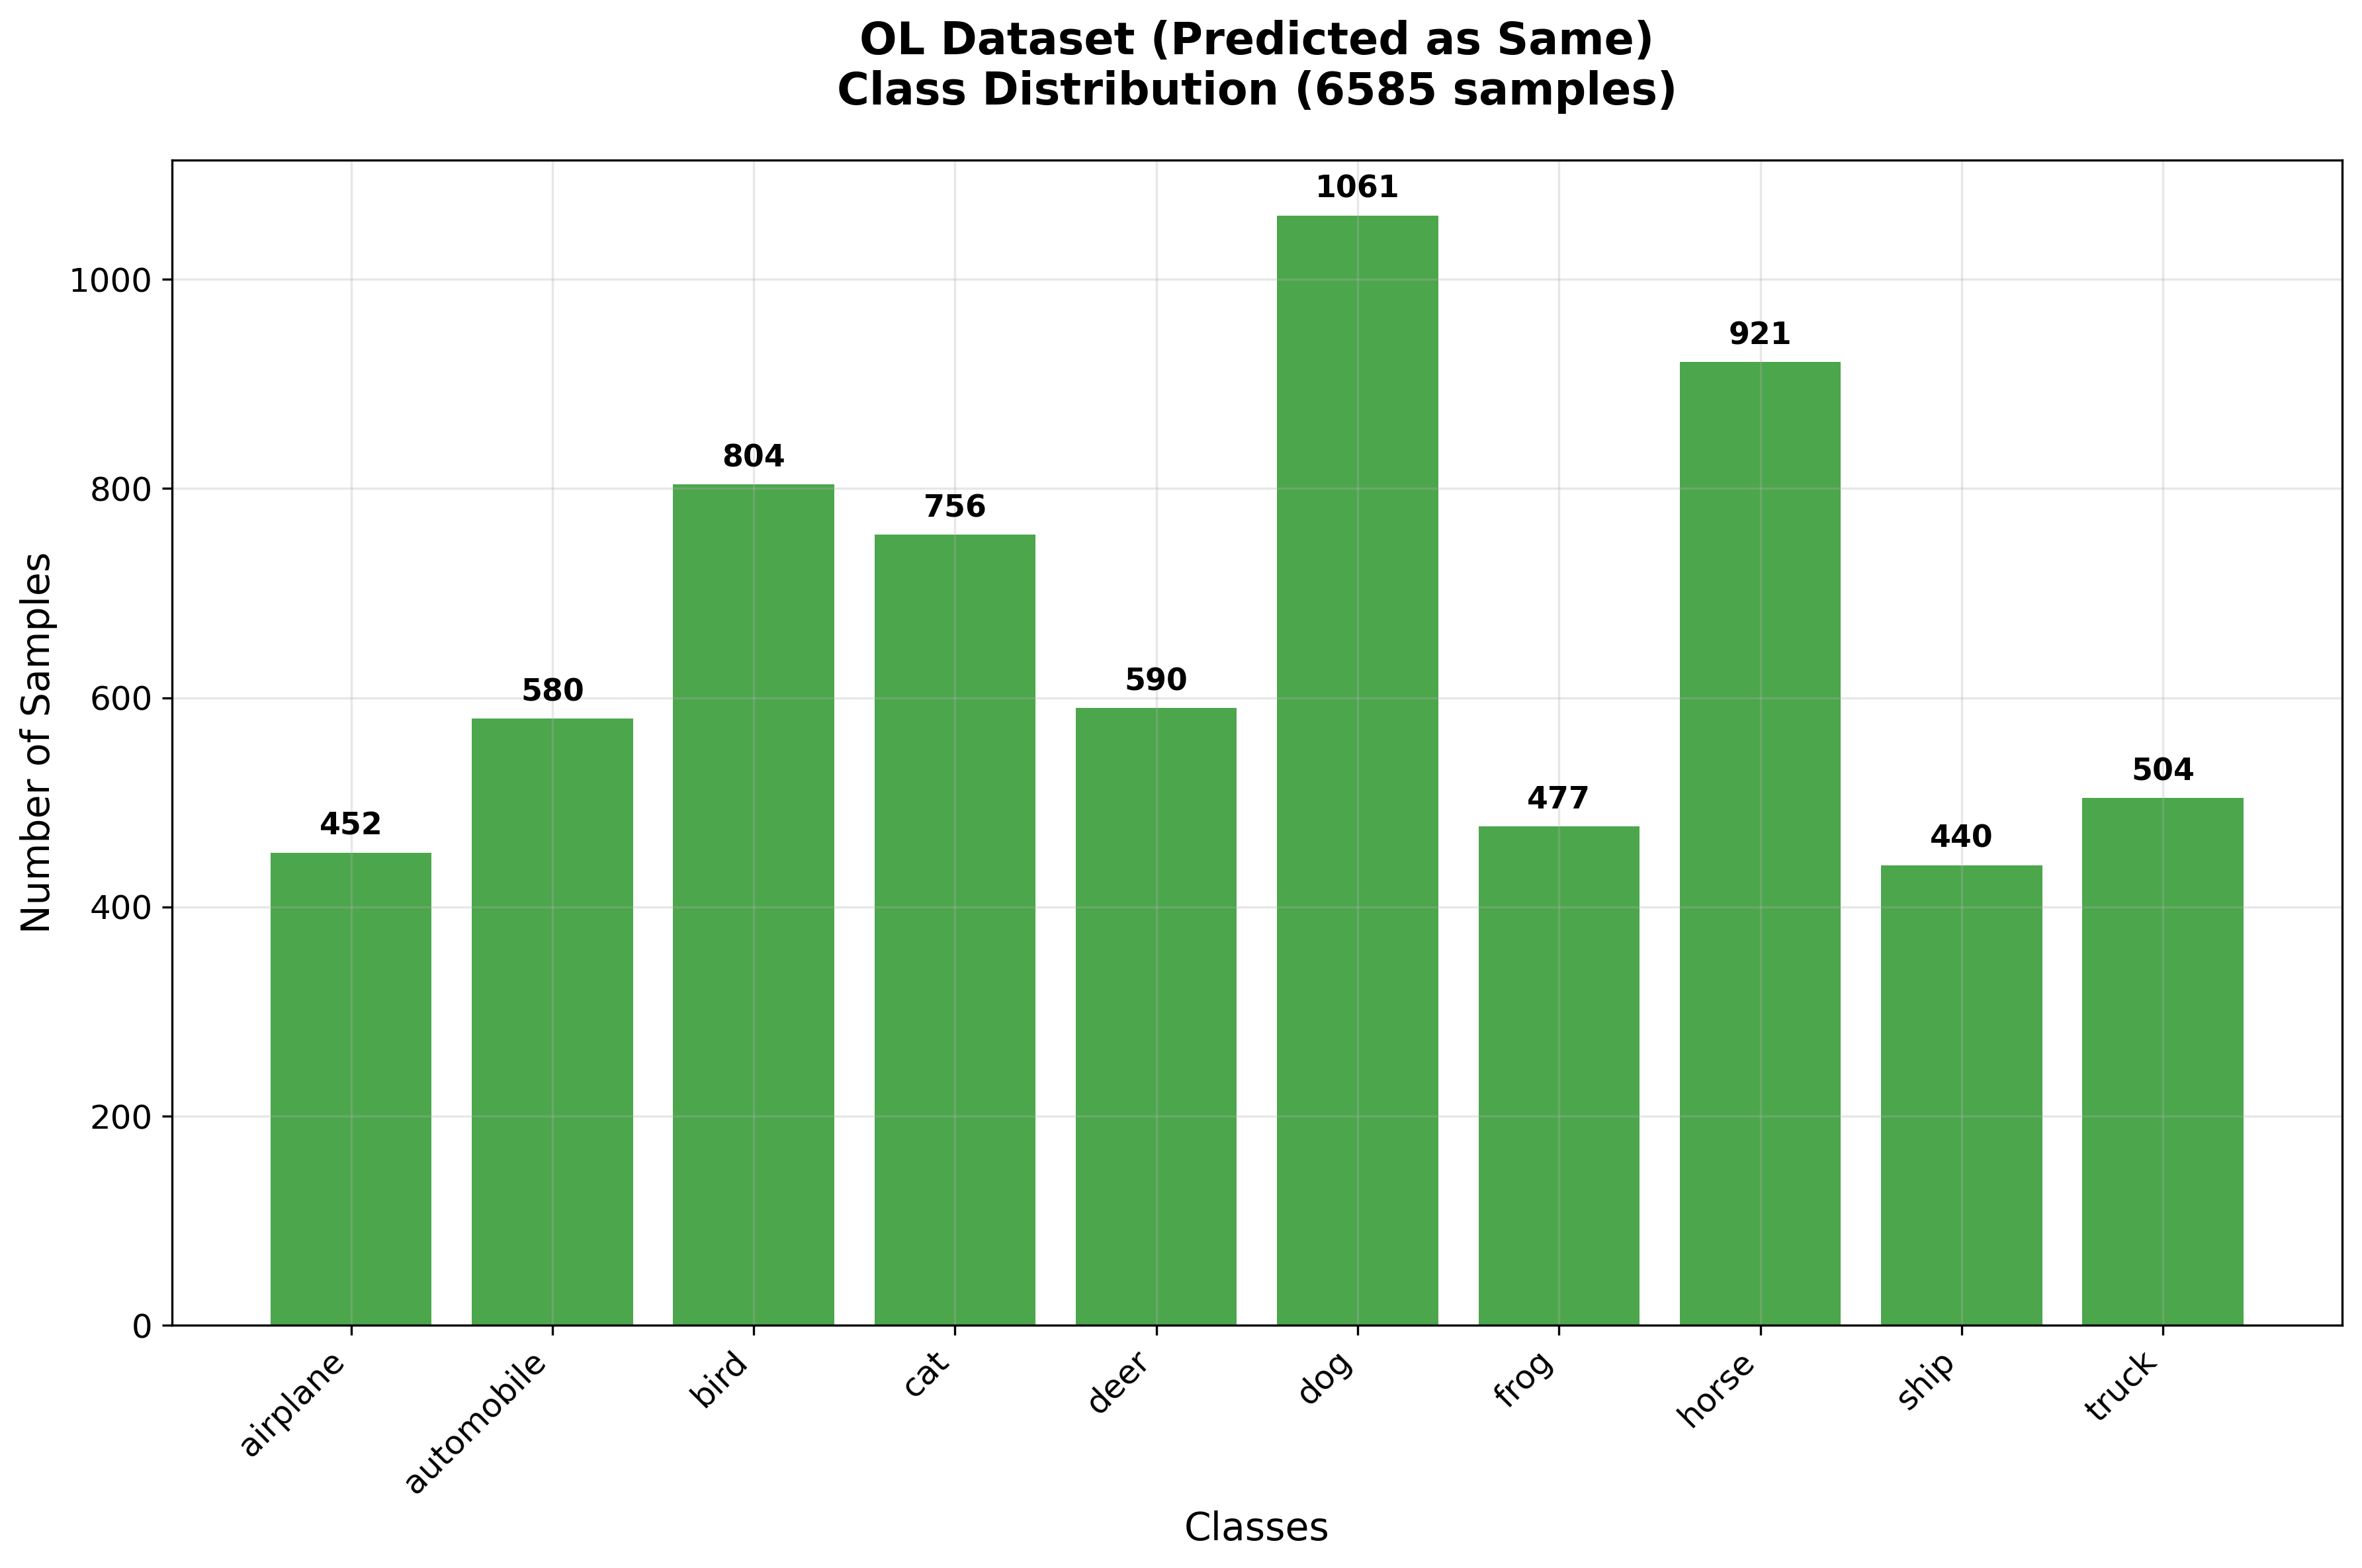

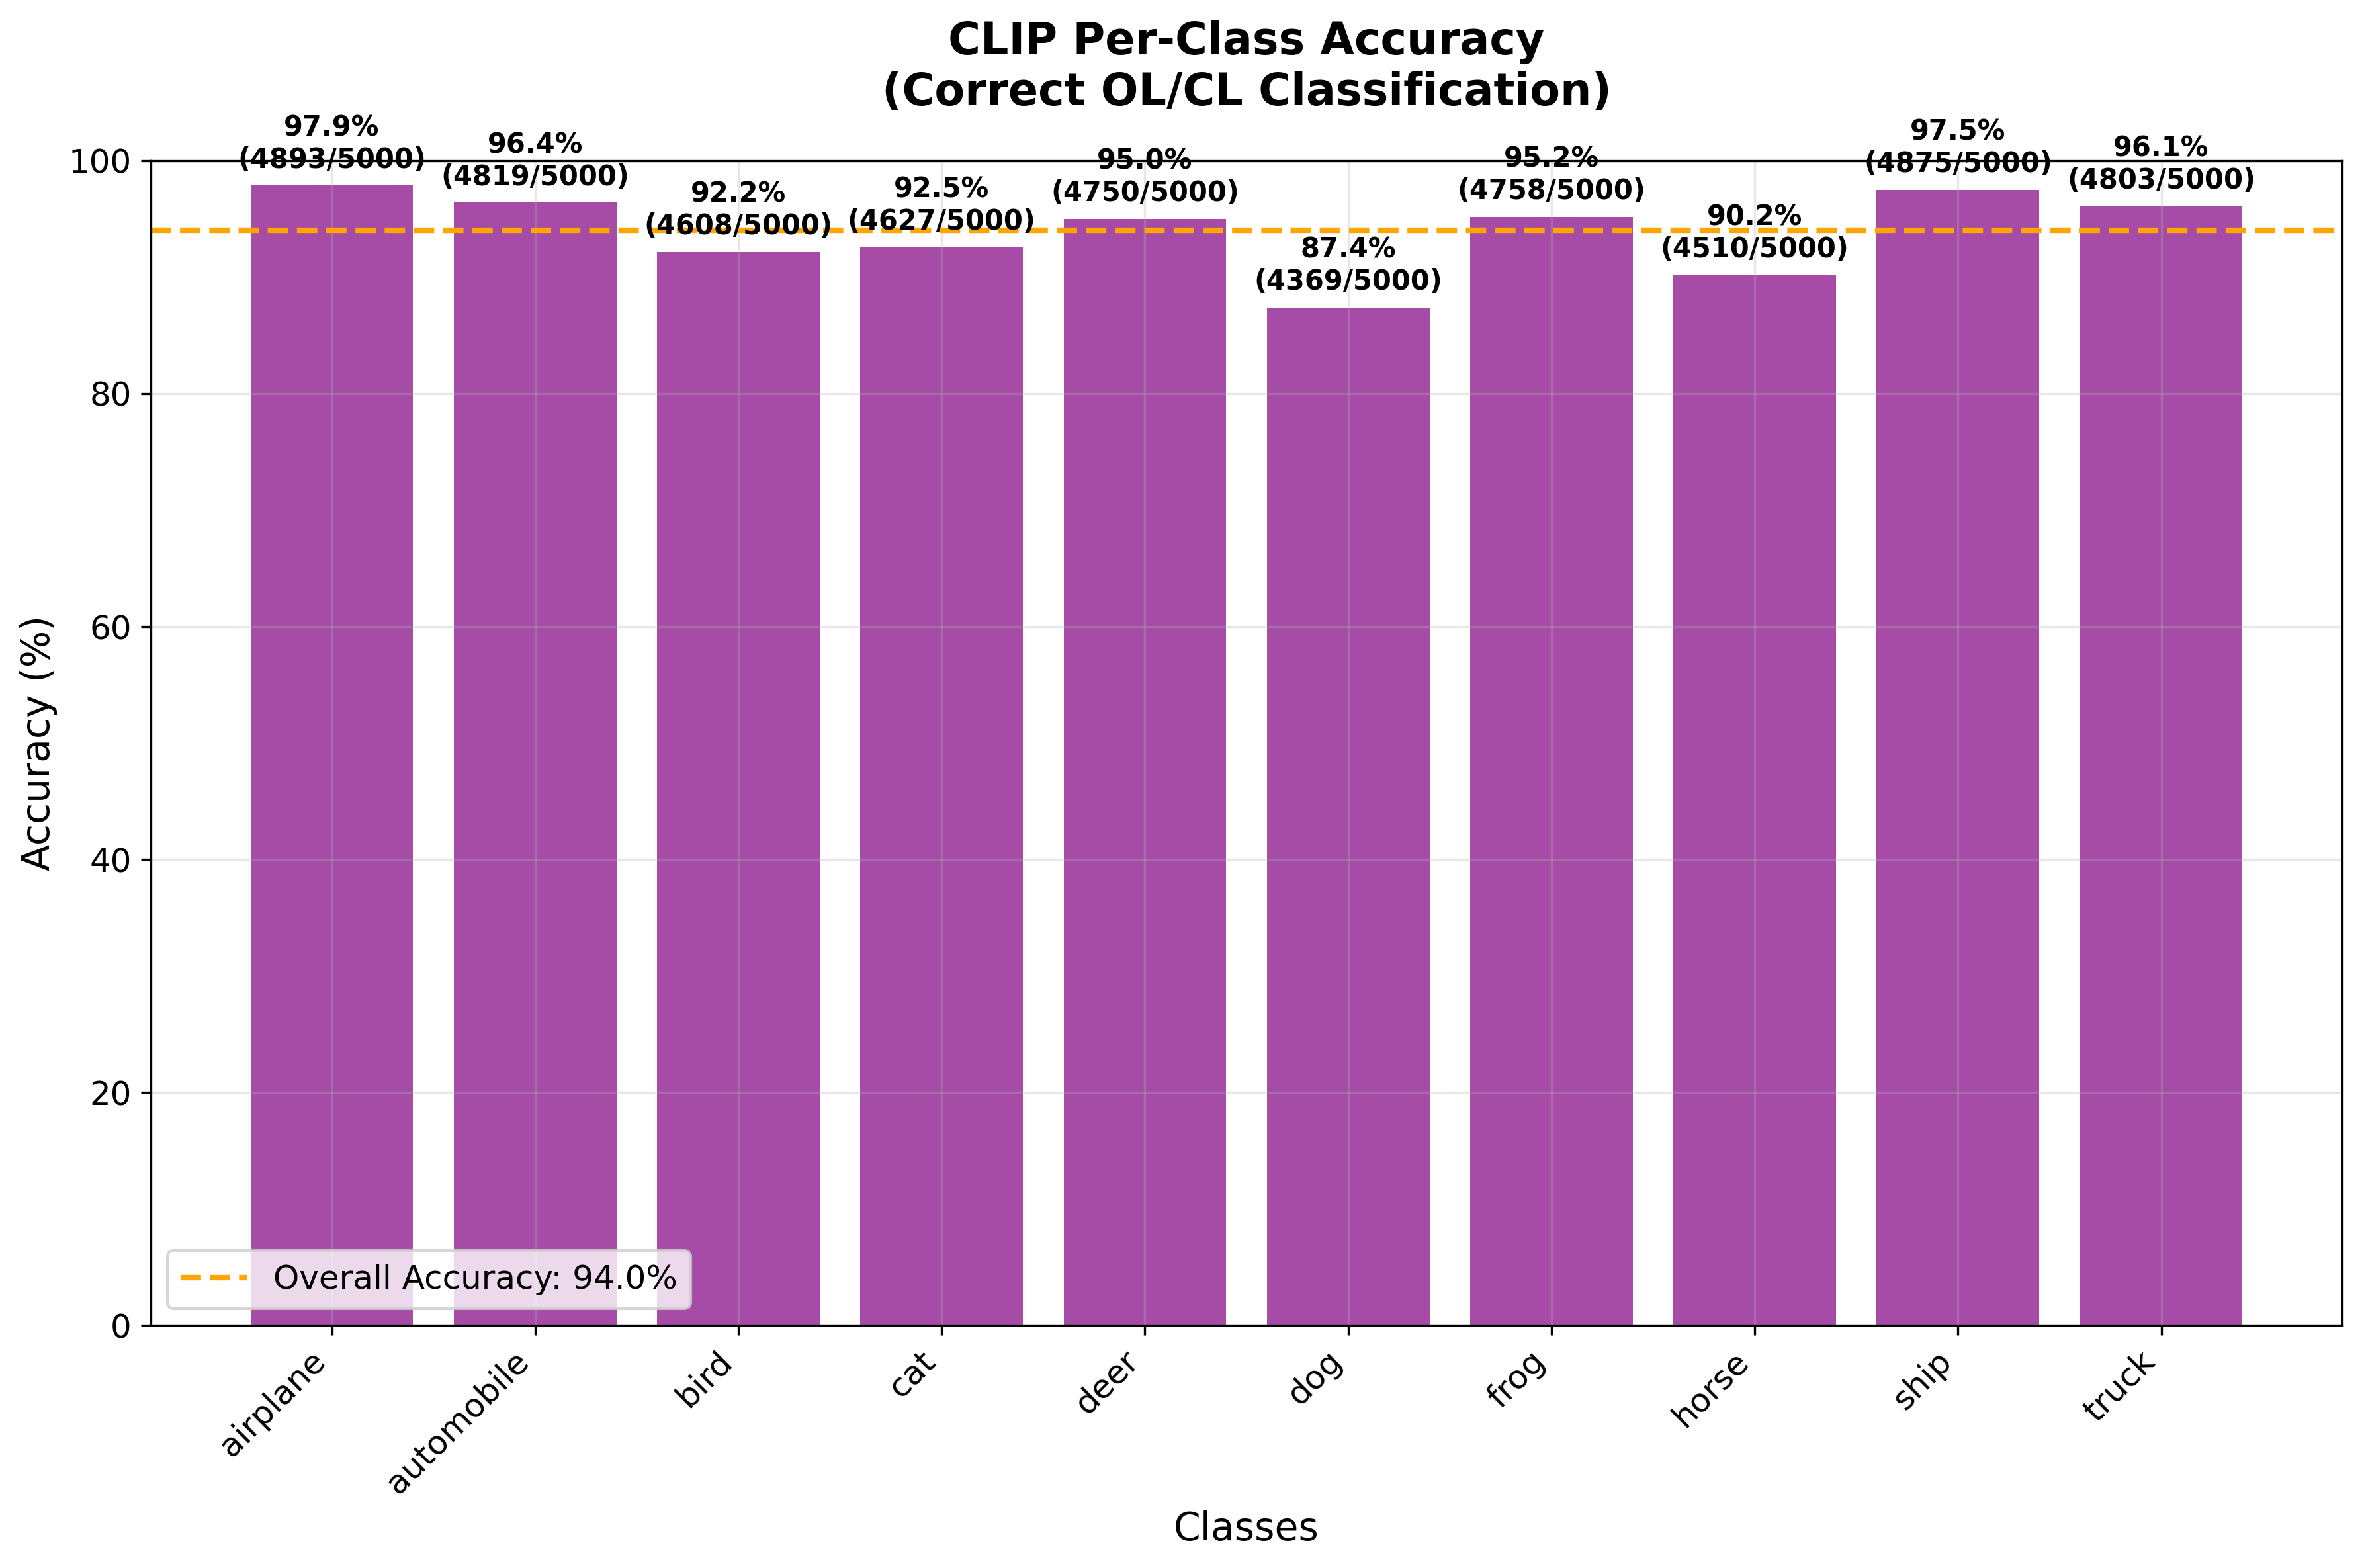


PER-CLASS ACCURACY ANALYSIS
Class        Total   Correct  Accuracy   CL Count  OL Count
-----------------------------------------------------------------
airplane     5000    4893        97.9%   4548      452
automobile   5000    4819        96.4%   4420      580
bird         5000    4608        92.2%   4196      804
cat          5000    4627        92.5%   4244      756
deer         5000    4750        95.0%   4410      590
dog          5000    4369        87.4%   3939      1061
frog         5000    4758        95.2%   4523      477
horse        5000    4510        90.2%   4079      921
ship         5000    4875        97.5%   4560      440
truck        5000    4803        96.1%   4496      504

CLASSES RANKED BY CLIP ACCURACY (Best to Worst)
 1. airplane    :  97.9% (4893/5000) - CL: 4548, OL: 452
 2. ship        :  97.5% (4875/5000) - CL: 4560, OL: 440
 3. automobile  :  96.4% (4819/5000) - CL: 4420, OL: 580
 4. truck       :  96.1% (4803/5000) - CL: 4496, OL: 504
 5. frog        :

In [31]:
# Class Distribution Analysis: CL/OL Split and Per-Class Accuracy
print("="*70)
print("CLASS DISTRIBUTION ANALYSIS & PER-CLASS ACCURACY")
print("="*70)

# Get shuffled labels for all samples (these are the classes we're analyzing)
shuffled_labels_all = []
for i in range(len(shuffled_dataset)):
    _, label = shuffled_dataset[i]
    shuffled_labels_all.append(label)

shuffled_labels_all = np.array(shuffled_labels_all)
class_names = shuffled_dataset.classes

print(f"Total samples: {len(shuffled_labels_all)}")
print(f"Predictions available for: {len(preds)} samples")

# Get predictions for all samples (use a simple approach if preds is shorter)
if len(preds) < len(shuffled_labels_all):
    print(f"Note: Using predictions for first {len(preds)} samples only")
    shuffled_labels_subset = shuffled_labels_all[:len(preds)]
else:
    shuffled_labels_subset = shuffled_labels_all
    
# Split into CL and OL based on predictions
cl_mask = (preds == 0)  # Complementary Learning samples
ol_mask = (preds == 1)  # Ordinary Learning samples

cl_labels = shuffled_labels_subset[cl_mask]
ol_labels = shuffled_labels_subset[ol_mask]

print(f"CL samples: {len(cl_labels)}")
print(f"OL samples: {len(ol_labels)}")

# Count class distributions
cl_class_counts = np.bincount(cl_labels, minlength=len(class_names))
ol_class_counts = np.bincount(ol_labels, minlength=len(class_names))

# Calculate per-class accuracy using ground truth
gts_subset = np.array(gts)[:len(preds)]
class_accuracies = []
class_total_counts = []
class_correct_counts = []

for class_idx in range(len(class_names)):
    # Get all samples of this class from shuffled dataset
    class_mask = (shuffled_labels_subset == class_idx)
    
    if class_mask.sum() > 0:
        # Get predictions and ground truth for this class
        class_preds = preds[class_mask]
        class_gts = gts_subset[class_mask]
        
        # Calculate accuracy for this class
        correct = (class_preds == class_gts).sum()
        total = len(class_preds)
        accuracy = correct / total if total > 0 else 0
        
        class_accuracies.append(accuracy)
        class_total_counts.append(total)
        class_correct_counts.append(correct)
    else:
        class_accuracies.append(0)
        class_total_counts.append(0)
        class_correct_counts.append(0)

# Set global DPI for all plots
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# 1. CL (Complementary Learning) distribution - Individual Plot
plt.figure(figsize=(12, 8))
bars1 = plt.bar(range(len(class_names)), cl_class_counts, color='red', alpha=0.7)
plt.title(f'CL Dataset (Predicted as Different)\nClass Distribution ({len(cl_labels)} samples)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(cl_class_counts):
    if v > 0:
        plt.text(i, v + max(cl_class_counts)*0.01, str(v), ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# 2. OL (Ordinary Learning) distribution - Individual Plot
plt.figure(figsize=(12, 8))
bars2 = plt.bar(range(len(class_names)), ol_class_counts, color='green', alpha=0.7)
plt.title(f'OL Dataset (Predicted as Same)\nClass Distribution ({len(ol_labels)} samples)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(ol_class_counts):
    if v > 0:
        plt.text(i, v + max(ol_class_counts)*0.01, str(v), ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# 3. Per-Class Accuracy - Individual Plot
plt.figure(figsize=(12, 8))
accuracy_percentages = [acc * 100 for acc in class_accuracies]
bars3 = plt.bar(range(len(class_names)), accuracy_percentages, color='purple', alpha=0.7)
plt.title('CLIP Per-Class Accuracy\n(Correct OL/CL Classification)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)

# Add accuracy labels on bars
for i, (acc, correct, total) in enumerate(zip(accuracy_percentages, class_correct_counts, class_total_counts)):
    if total > 0:
        plt.text(i, acc + 1, f'{acc:.1f}%\n({correct}/{total})', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add horizontal line for overall accuracy
overall_accuracy = (np.array(preds) == gts_subset).sum() / len(preds) * 100
plt.axhline(overall_accuracy, color='orange', linestyle='--', linewidth=2, 
           label=f'Overall Accuracy: {overall_accuracy:.1f}%')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Reset DPI to default
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

# Print detailed statistics
print("\n" + "="*60)
print("PER-CLASS ACCURACY ANALYSIS")
print("="*60)

print(f"{'Class':<12} {'Total':<7} {'Correct':<8} {'Accuracy':<10} {'CL Count':<9} {'OL Count'}")
print("-" * 65)

for i, class_name in enumerate(class_names):
    accuracy_pct = class_accuracies[i] * 100
    print(f"{class_name:<12} {class_total_counts[i]:<7} {class_correct_counts[i]:<8} "
          f"{accuracy_pct:>7.1f}%   {cl_class_counts[i]:<9} {ol_class_counts[i]}")

# Sort classes by accuracy for insights
sorted_indices = np.argsort(class_accuracies)[::-1]  # Descending order

print(f"\n" + "="*50)
print("CLASSES RANKED BY CLIP ACCURACY (Best to Worst)")
print("="*50)

for i, idx in enumerate(sorted_indices):
    class_name = class_names[idx]
    accuracy_pct = class_accuracies[idx] * 100
    cl_count = cl_class_counts[idx]
    ol_count = ol_class_counts[idx]
    total_count = class_total_counts[idx]
    
    if total_count > 0:
        print(f"{i+1:2d}. {class_name:<12}: {accuracy_pct:5.1f}% "
              f"({class_correct_counts[idx]}/{total_count}) - "
              f"CL: {cl_count}, OL: {ol_count}")

print(f"\n" + "="*50)
print("KEY INSIGHTS")
print("="*50)

best_class_idx = sorted_indices[0]
worst_class_idx = sorted_indices[-1]
best_accuracy = class_accuracies[best_class_idx] * 100
worst_accuracy = class_accuracies[worst_class_idx] * 100

print(f"Best performing class: {class_names[best_class_idx]} ({best_accuracy:.1f}% accuracy)")
print(f"Worst performing class: {class_names[worst_class_idx]} ({worst_accuracy:.1f}% accuracy)")
print(f"Accuracy range: {worst_accuracy:.1f}% - {best_accuracy:.1f}% ({best_accuracy - worst_accuracy:.1f}% spread)")
print(f"Overall accuracy: {overall_accuracy:.1f}%")

# Classes above/below average
above_avg = [i for i, acc in enumerate(class_accuracies) if acc * 100 > overall_accuracy]
below_avg = [i for i, acc in enumerate(class_accuracies) if acc * 100 < overall_accuracy]

print(f"\nClasses above average accuracy: {[class_names[i] for i in above_avg]}")
print(f"Classes below average accuracy: {[class_names[i] for i in below_avg]}")

print(f"\nCL/OL Split Summary:")
print(f"Total CL samples: {len(cl_labels)} ({len(cl_labels)/(len(cl_labels)+len(ol_labels)):.1%})")
print(f"Total OL samples: {len(ol_labels)} ({len(ol_labels)/(len(cl_labels)+len(ol_labels)):.1%})")

TRANSITION ANALYSIS: SHUFFLED LABELS → BINARY CL/OL PREDICTIONS
Using existing predictions and labels...
Total samples processed: 50000
Predictions available: 50000


TRANSITION ANALYSIS: SHUFFLED LABELS → BINARY CL/OL PREDICTIONS
Using existing predictions and labels...
Total samples processed: 50000
Predictions available: 50000


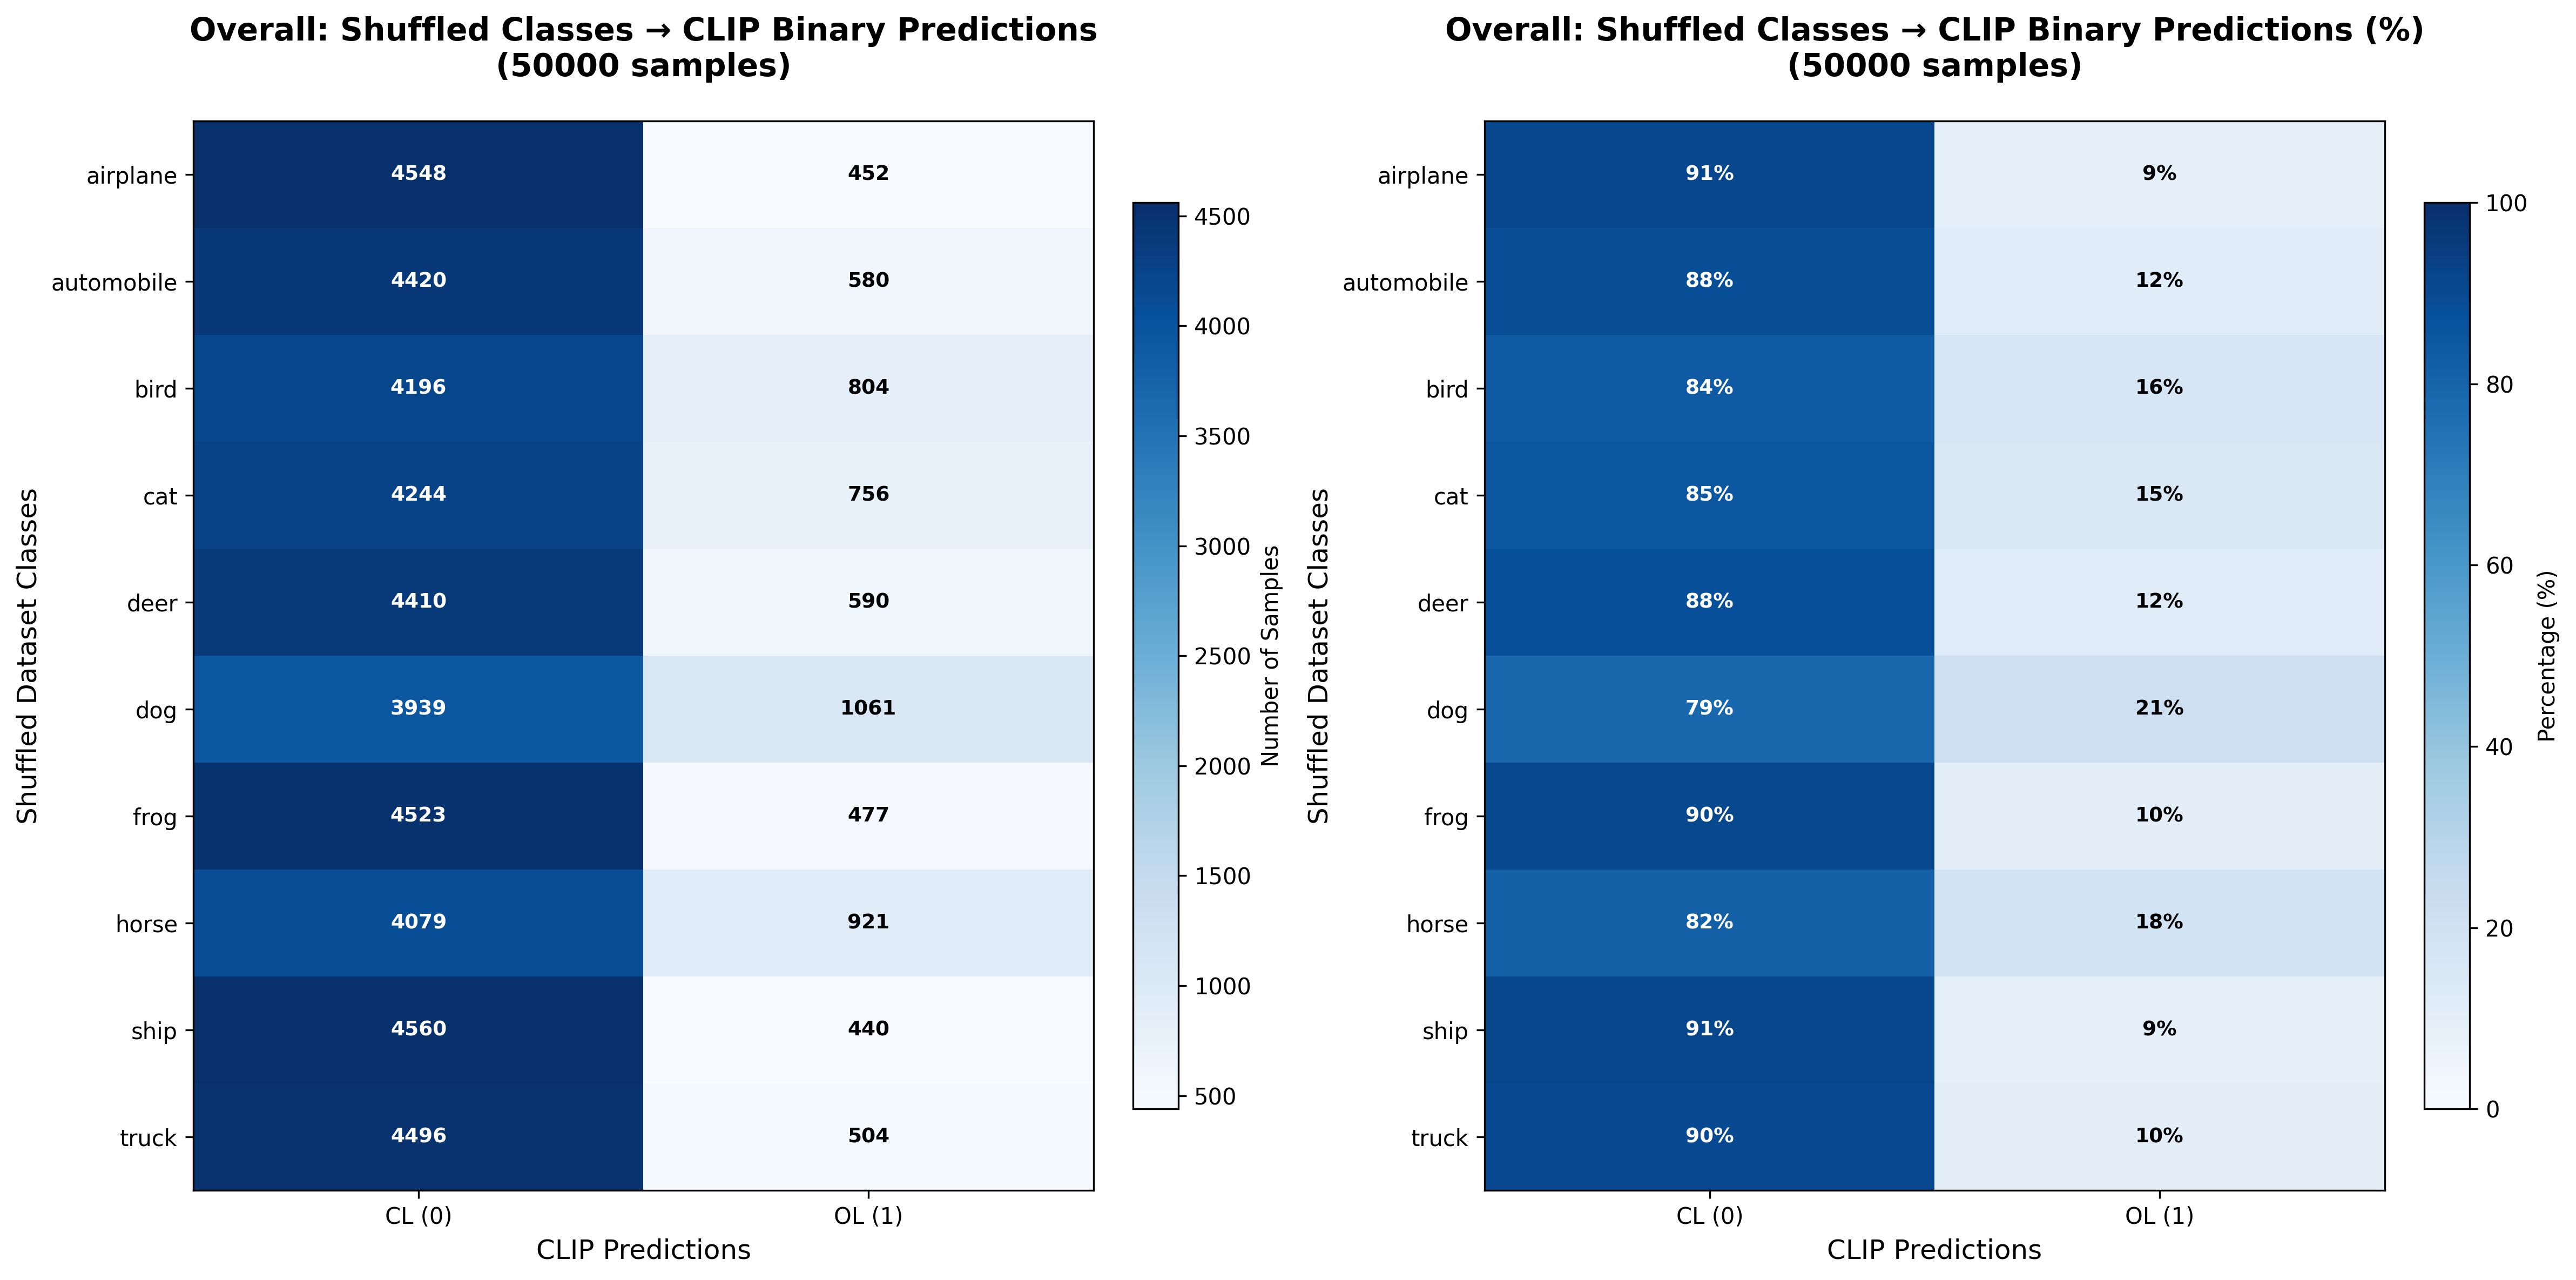

TRANSITION ANALYSIS: SHUFFLED LABELS → BINARY CL/OL PREDICTIONS
Using existing predictions and labels...
Total samples processed: 50000
Predictions available: 50000


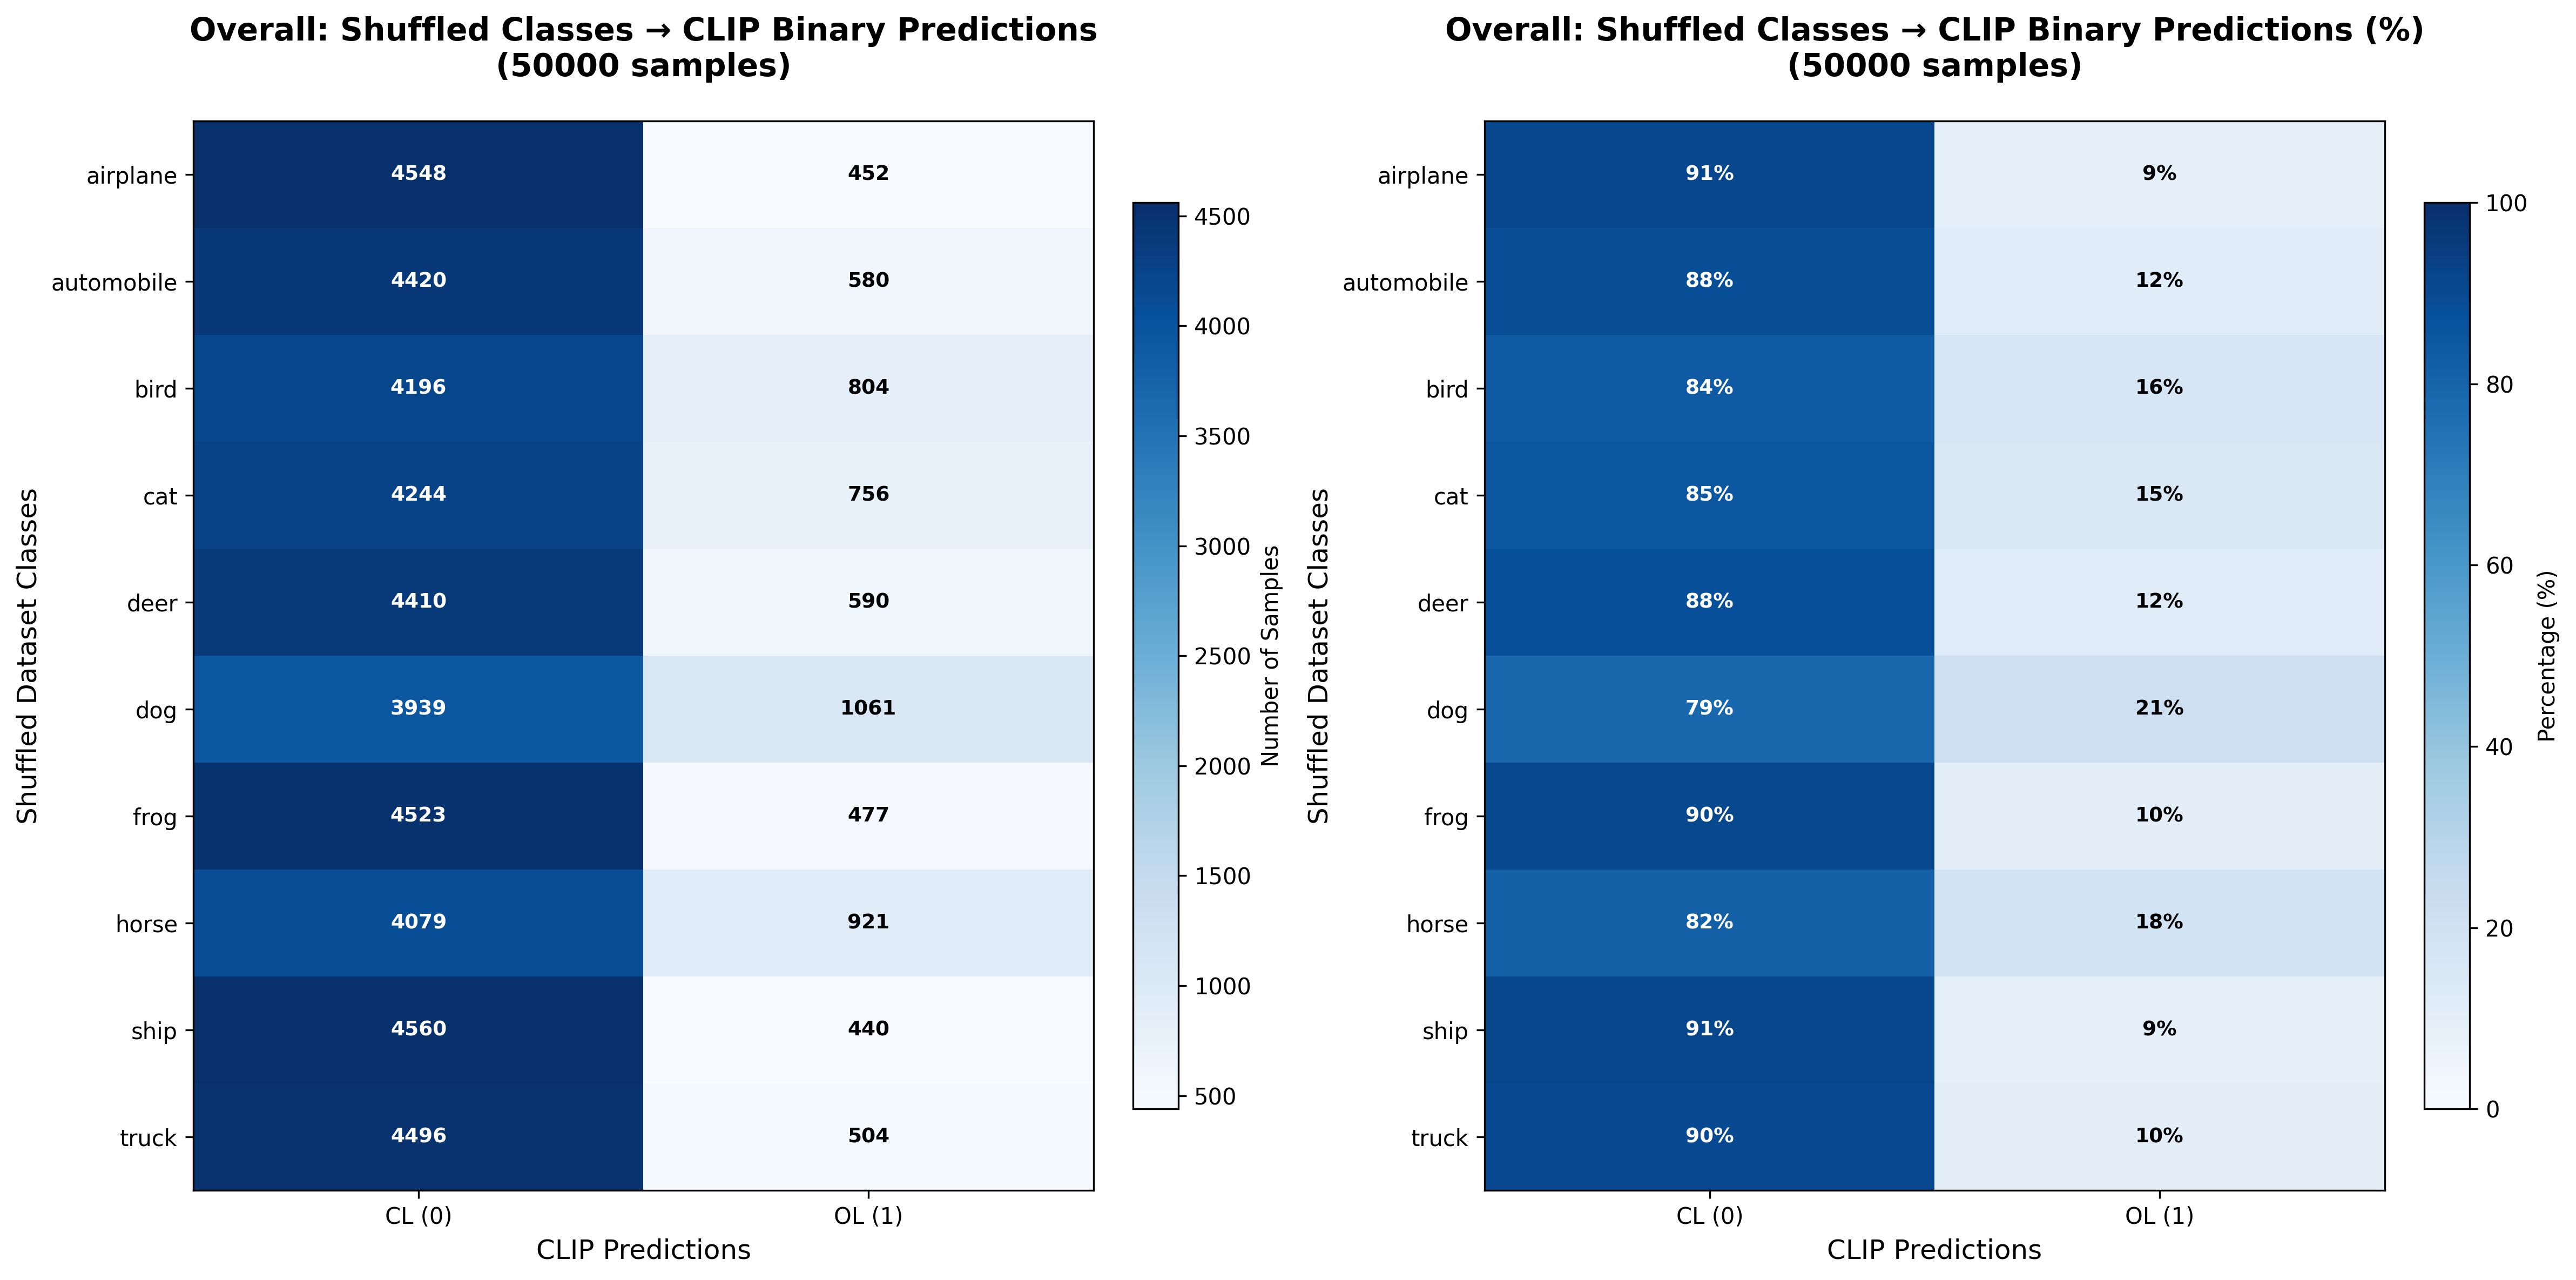

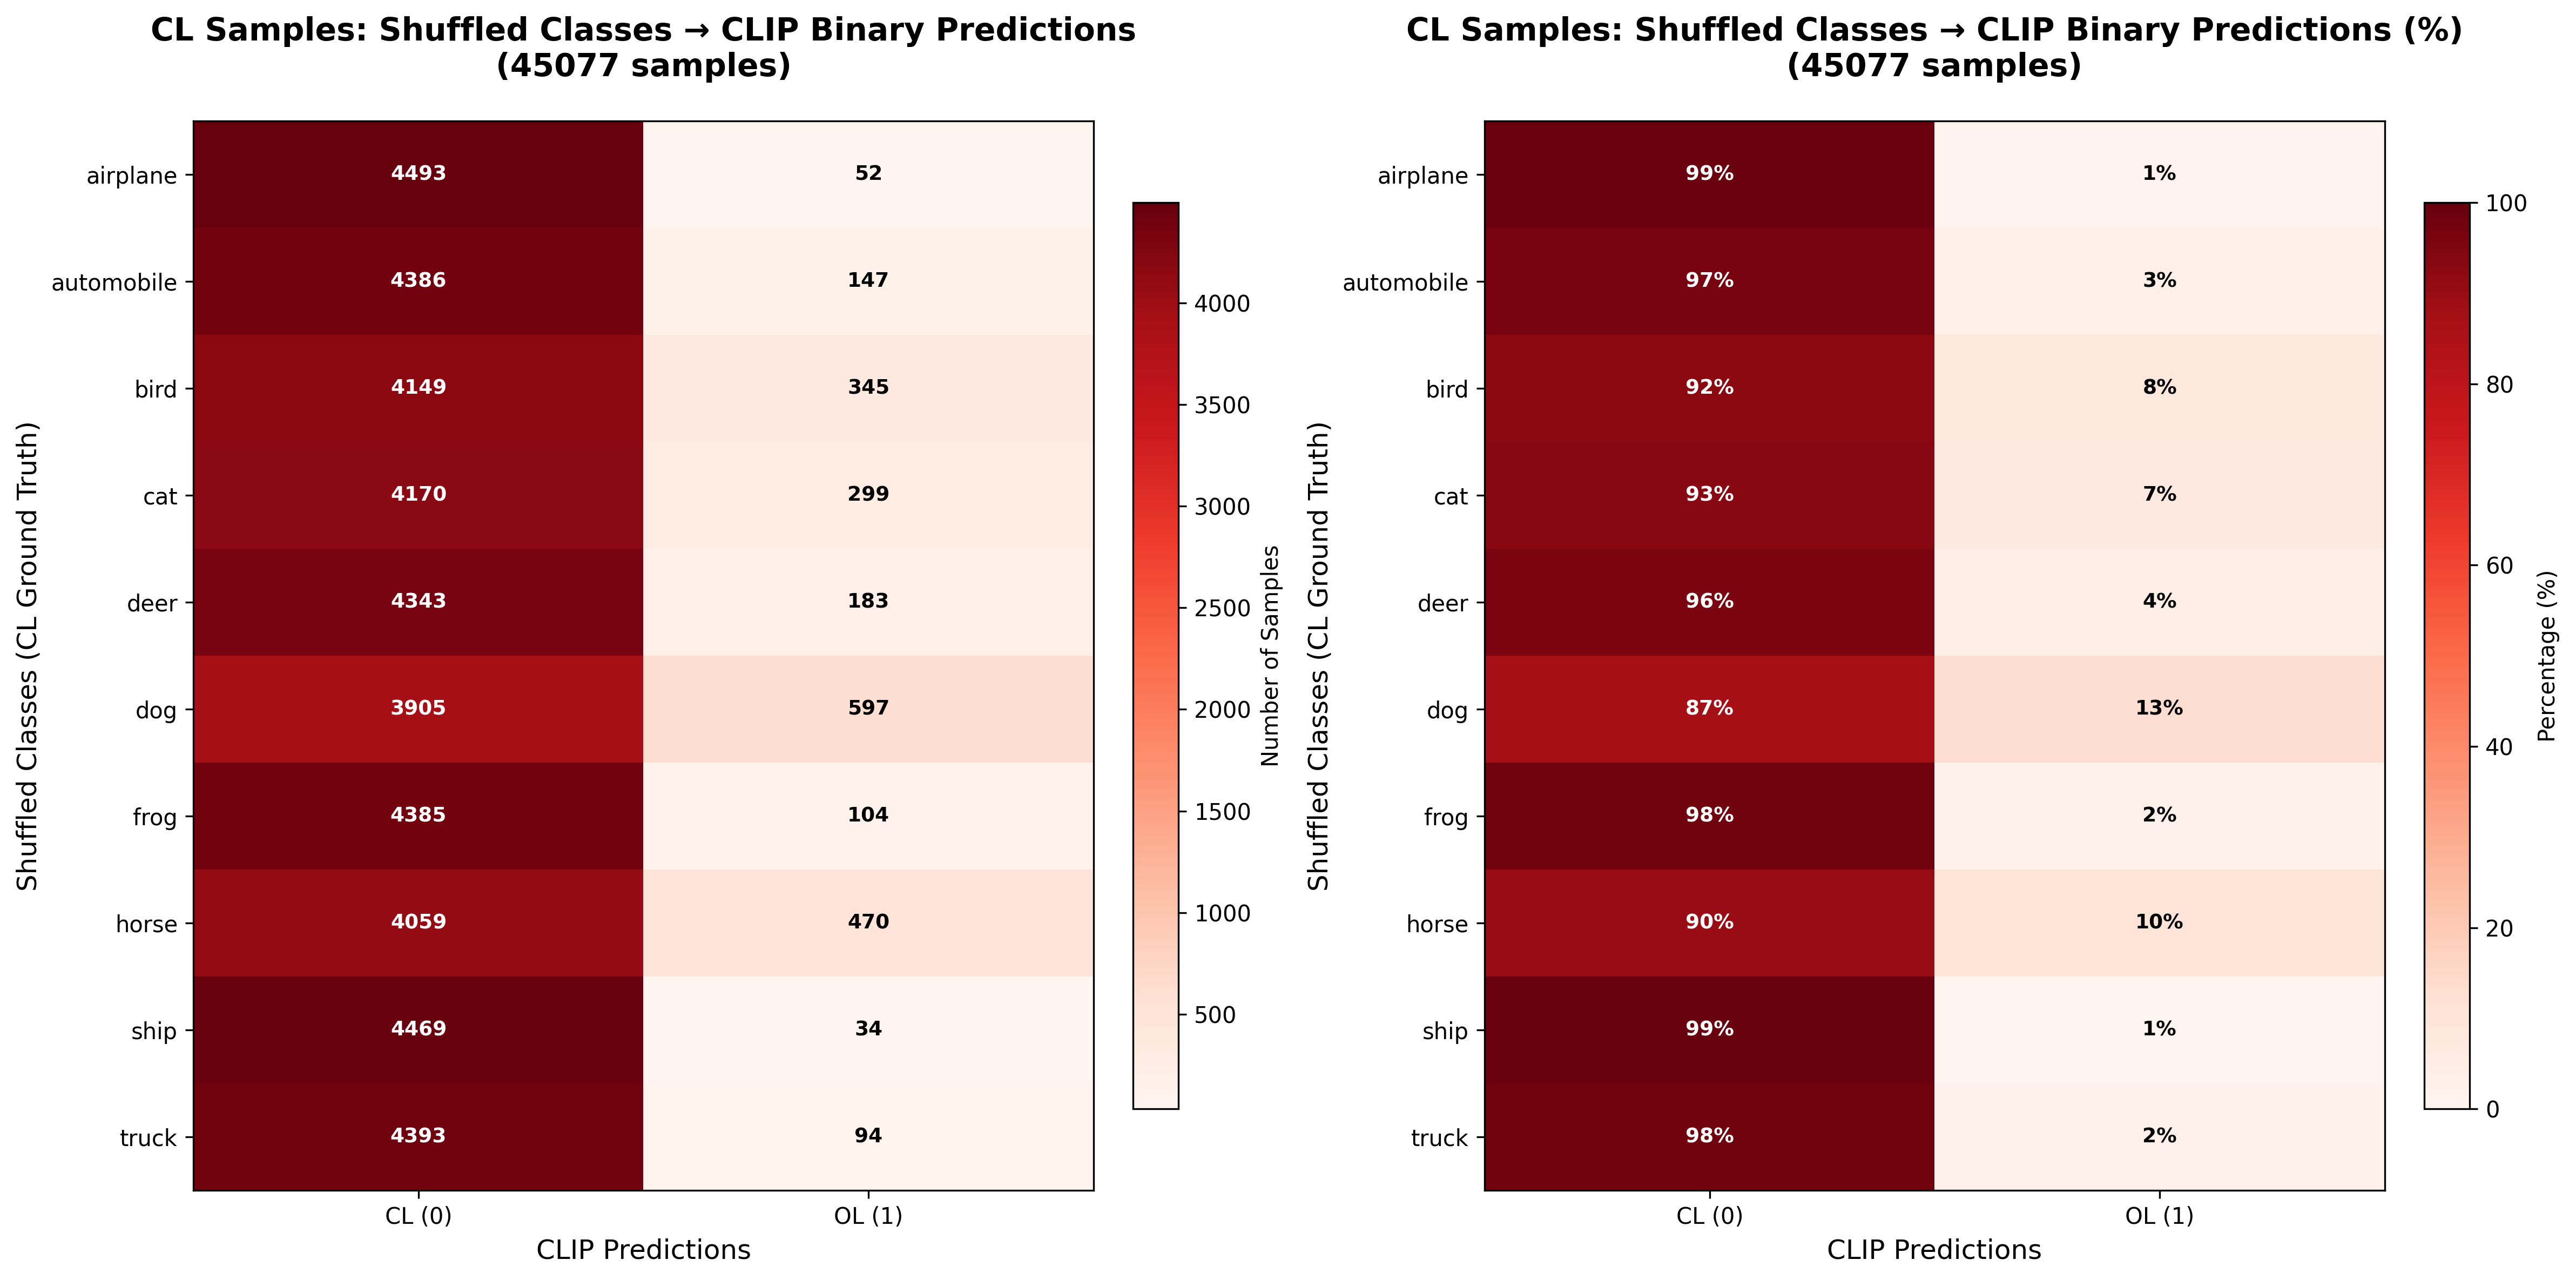

TRANSITION ANALYSIS: SHUFFLED LABELS → BINARY CL/OL PREDICTIONS
Using existing predictions and labels...
Total samples processed: 50000
Predictions available: 50000


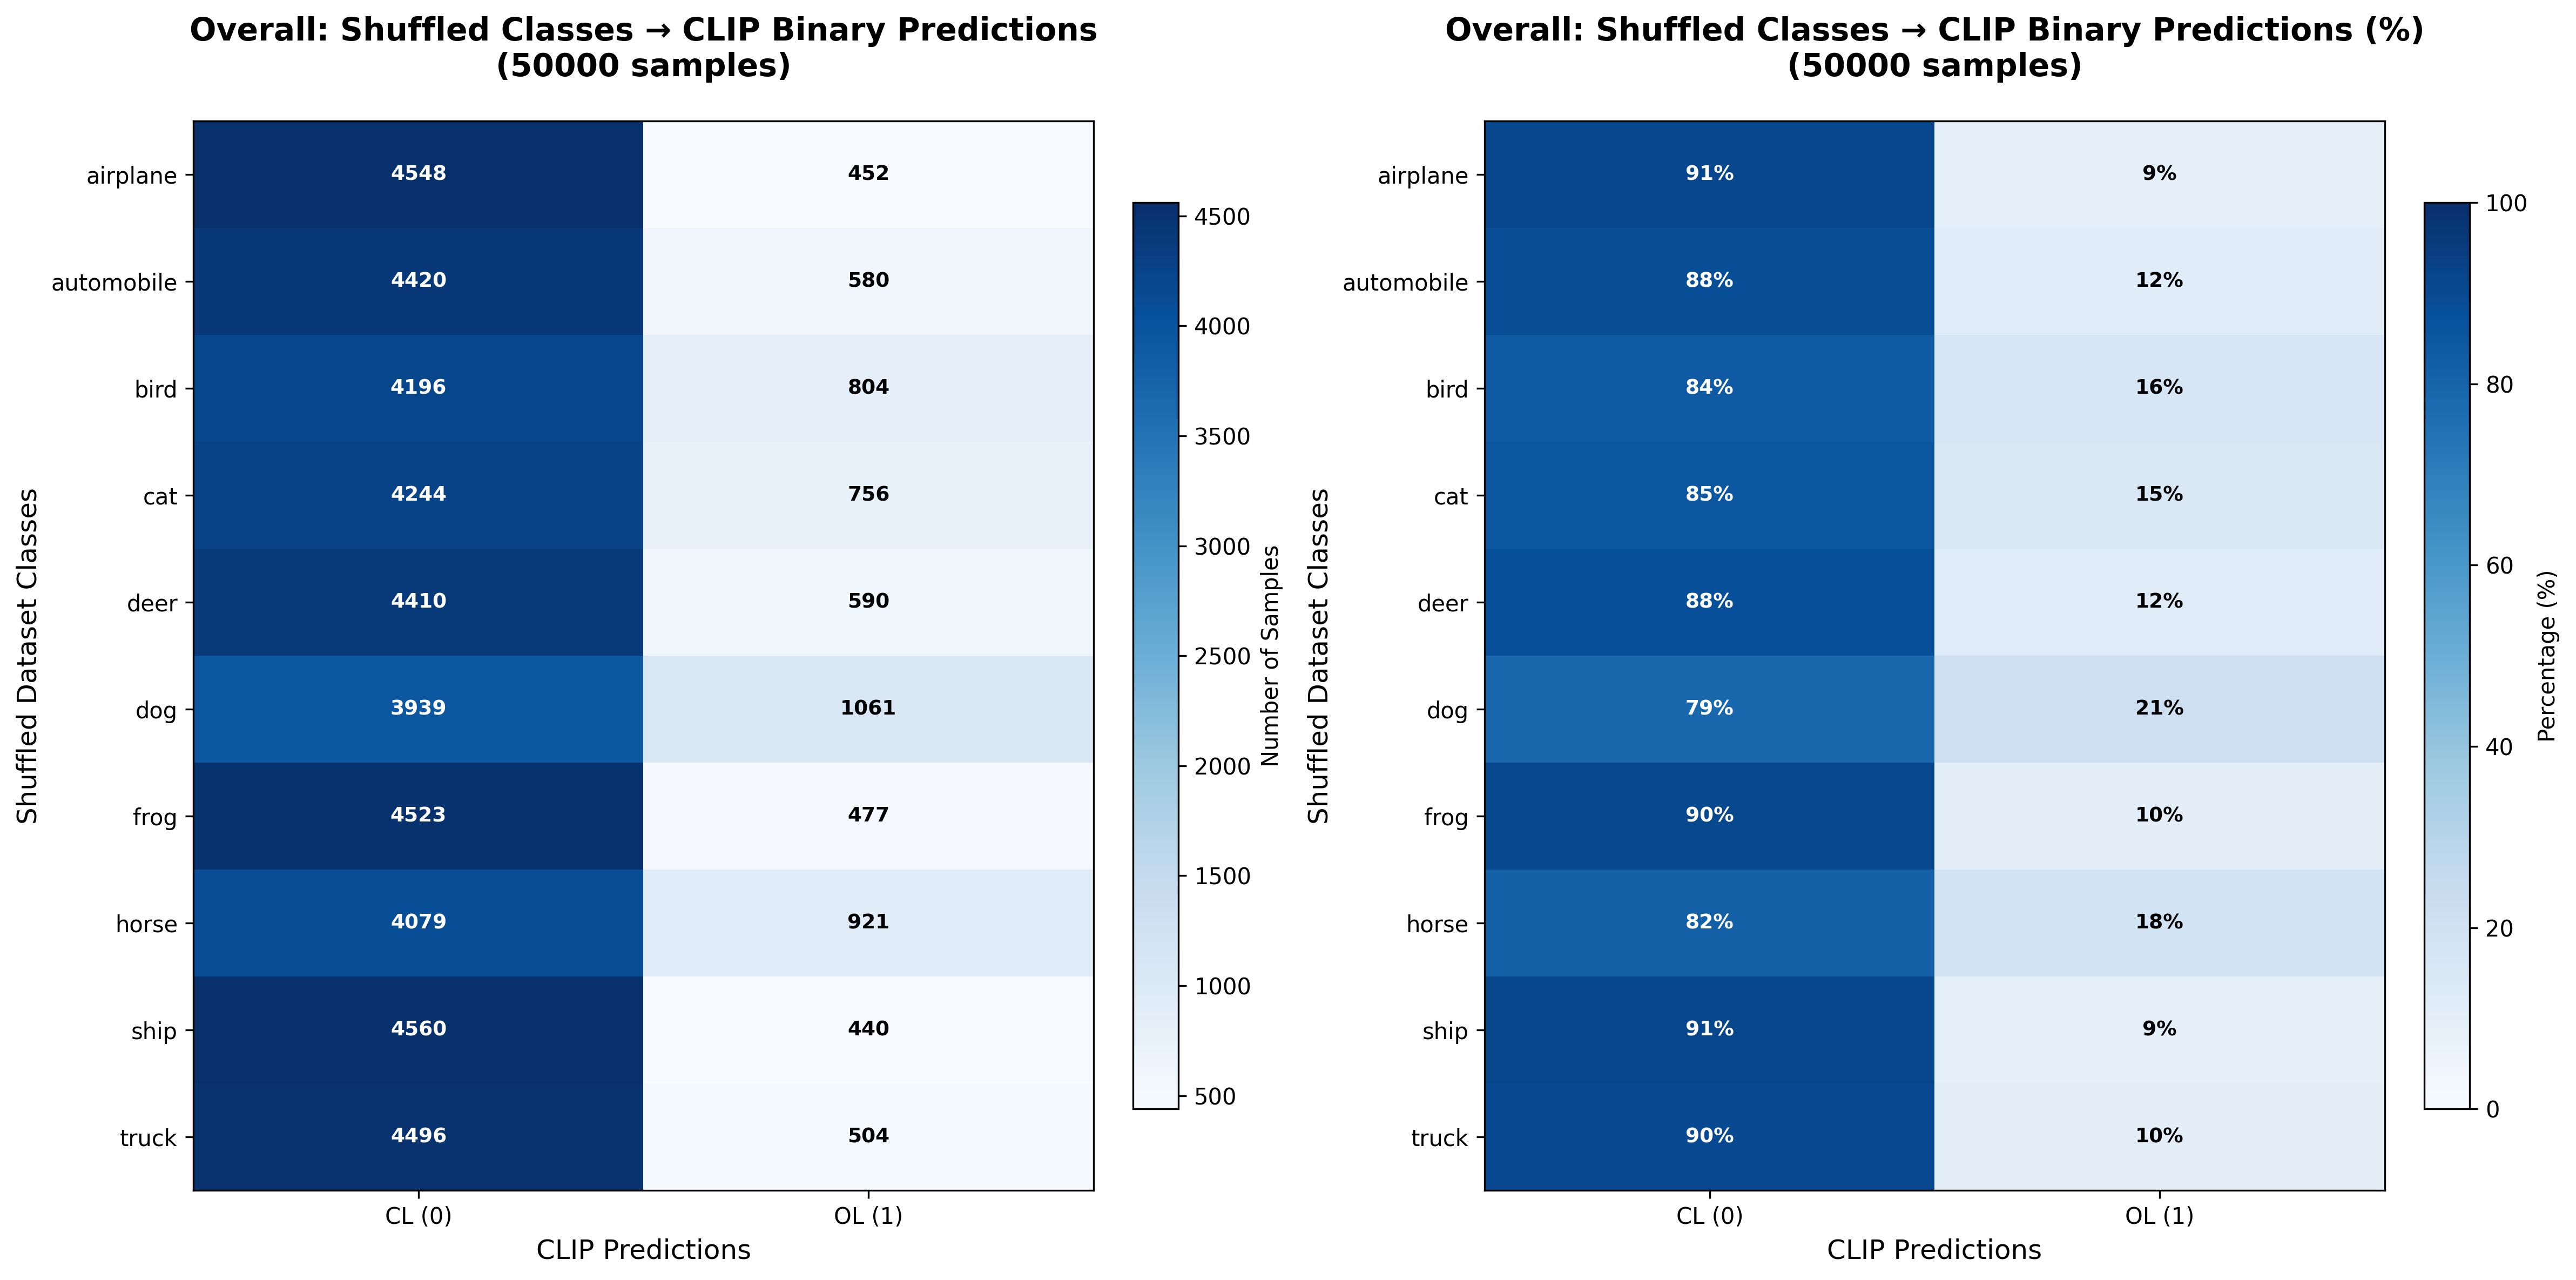

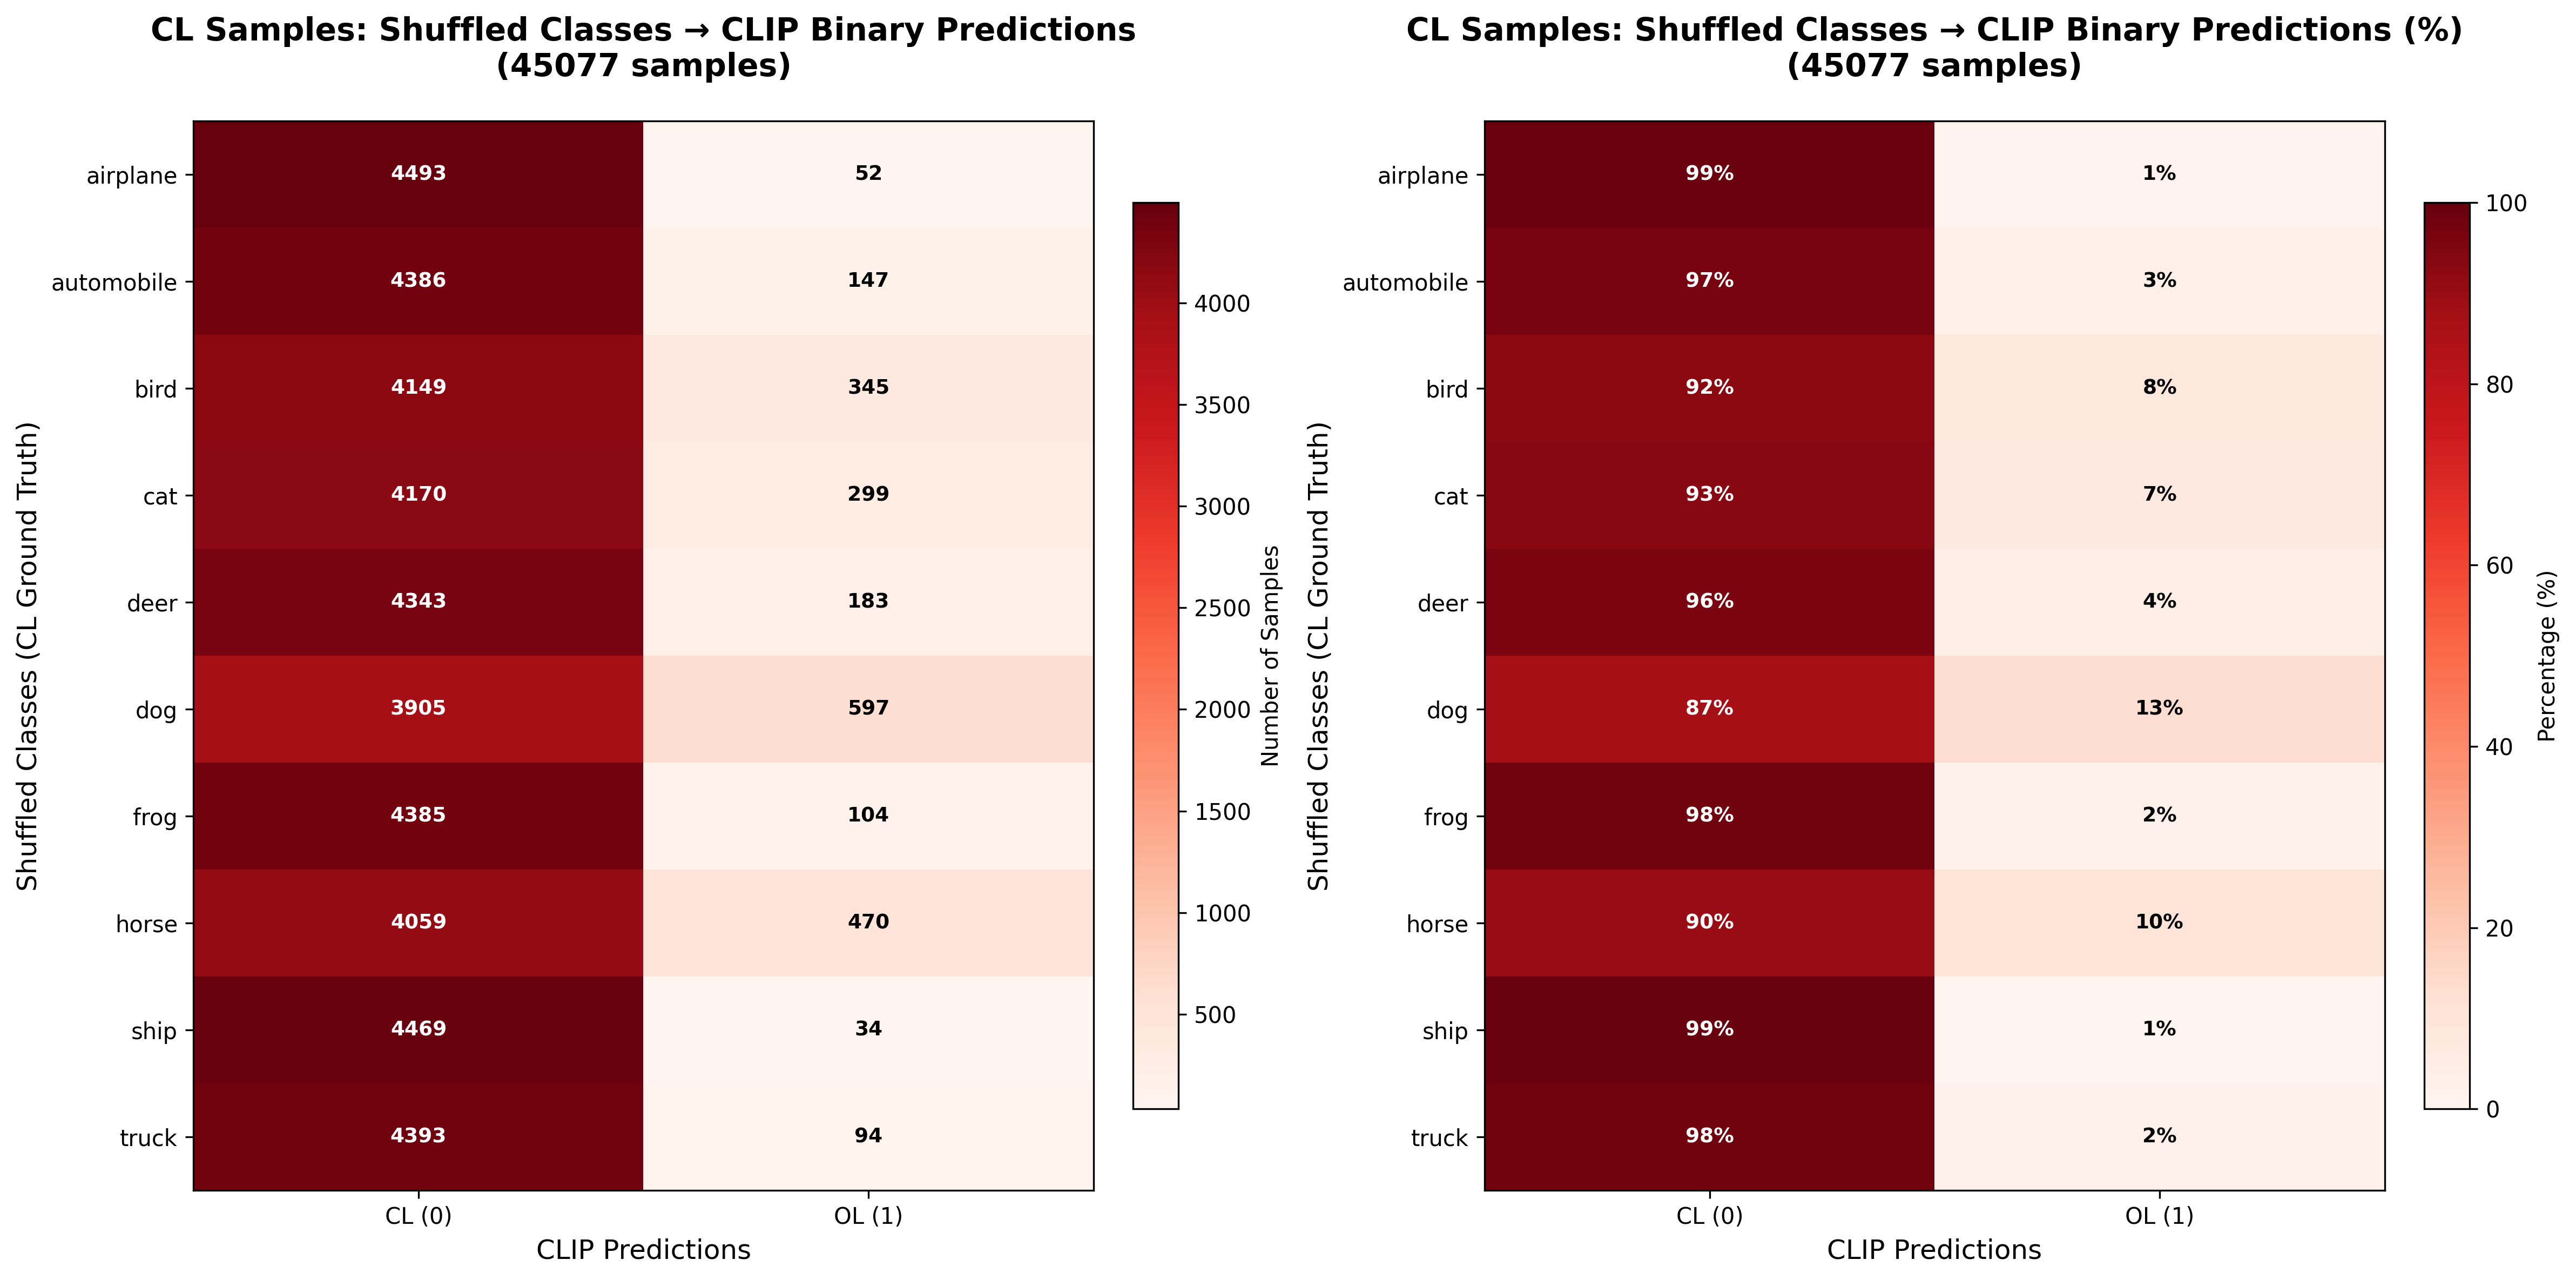

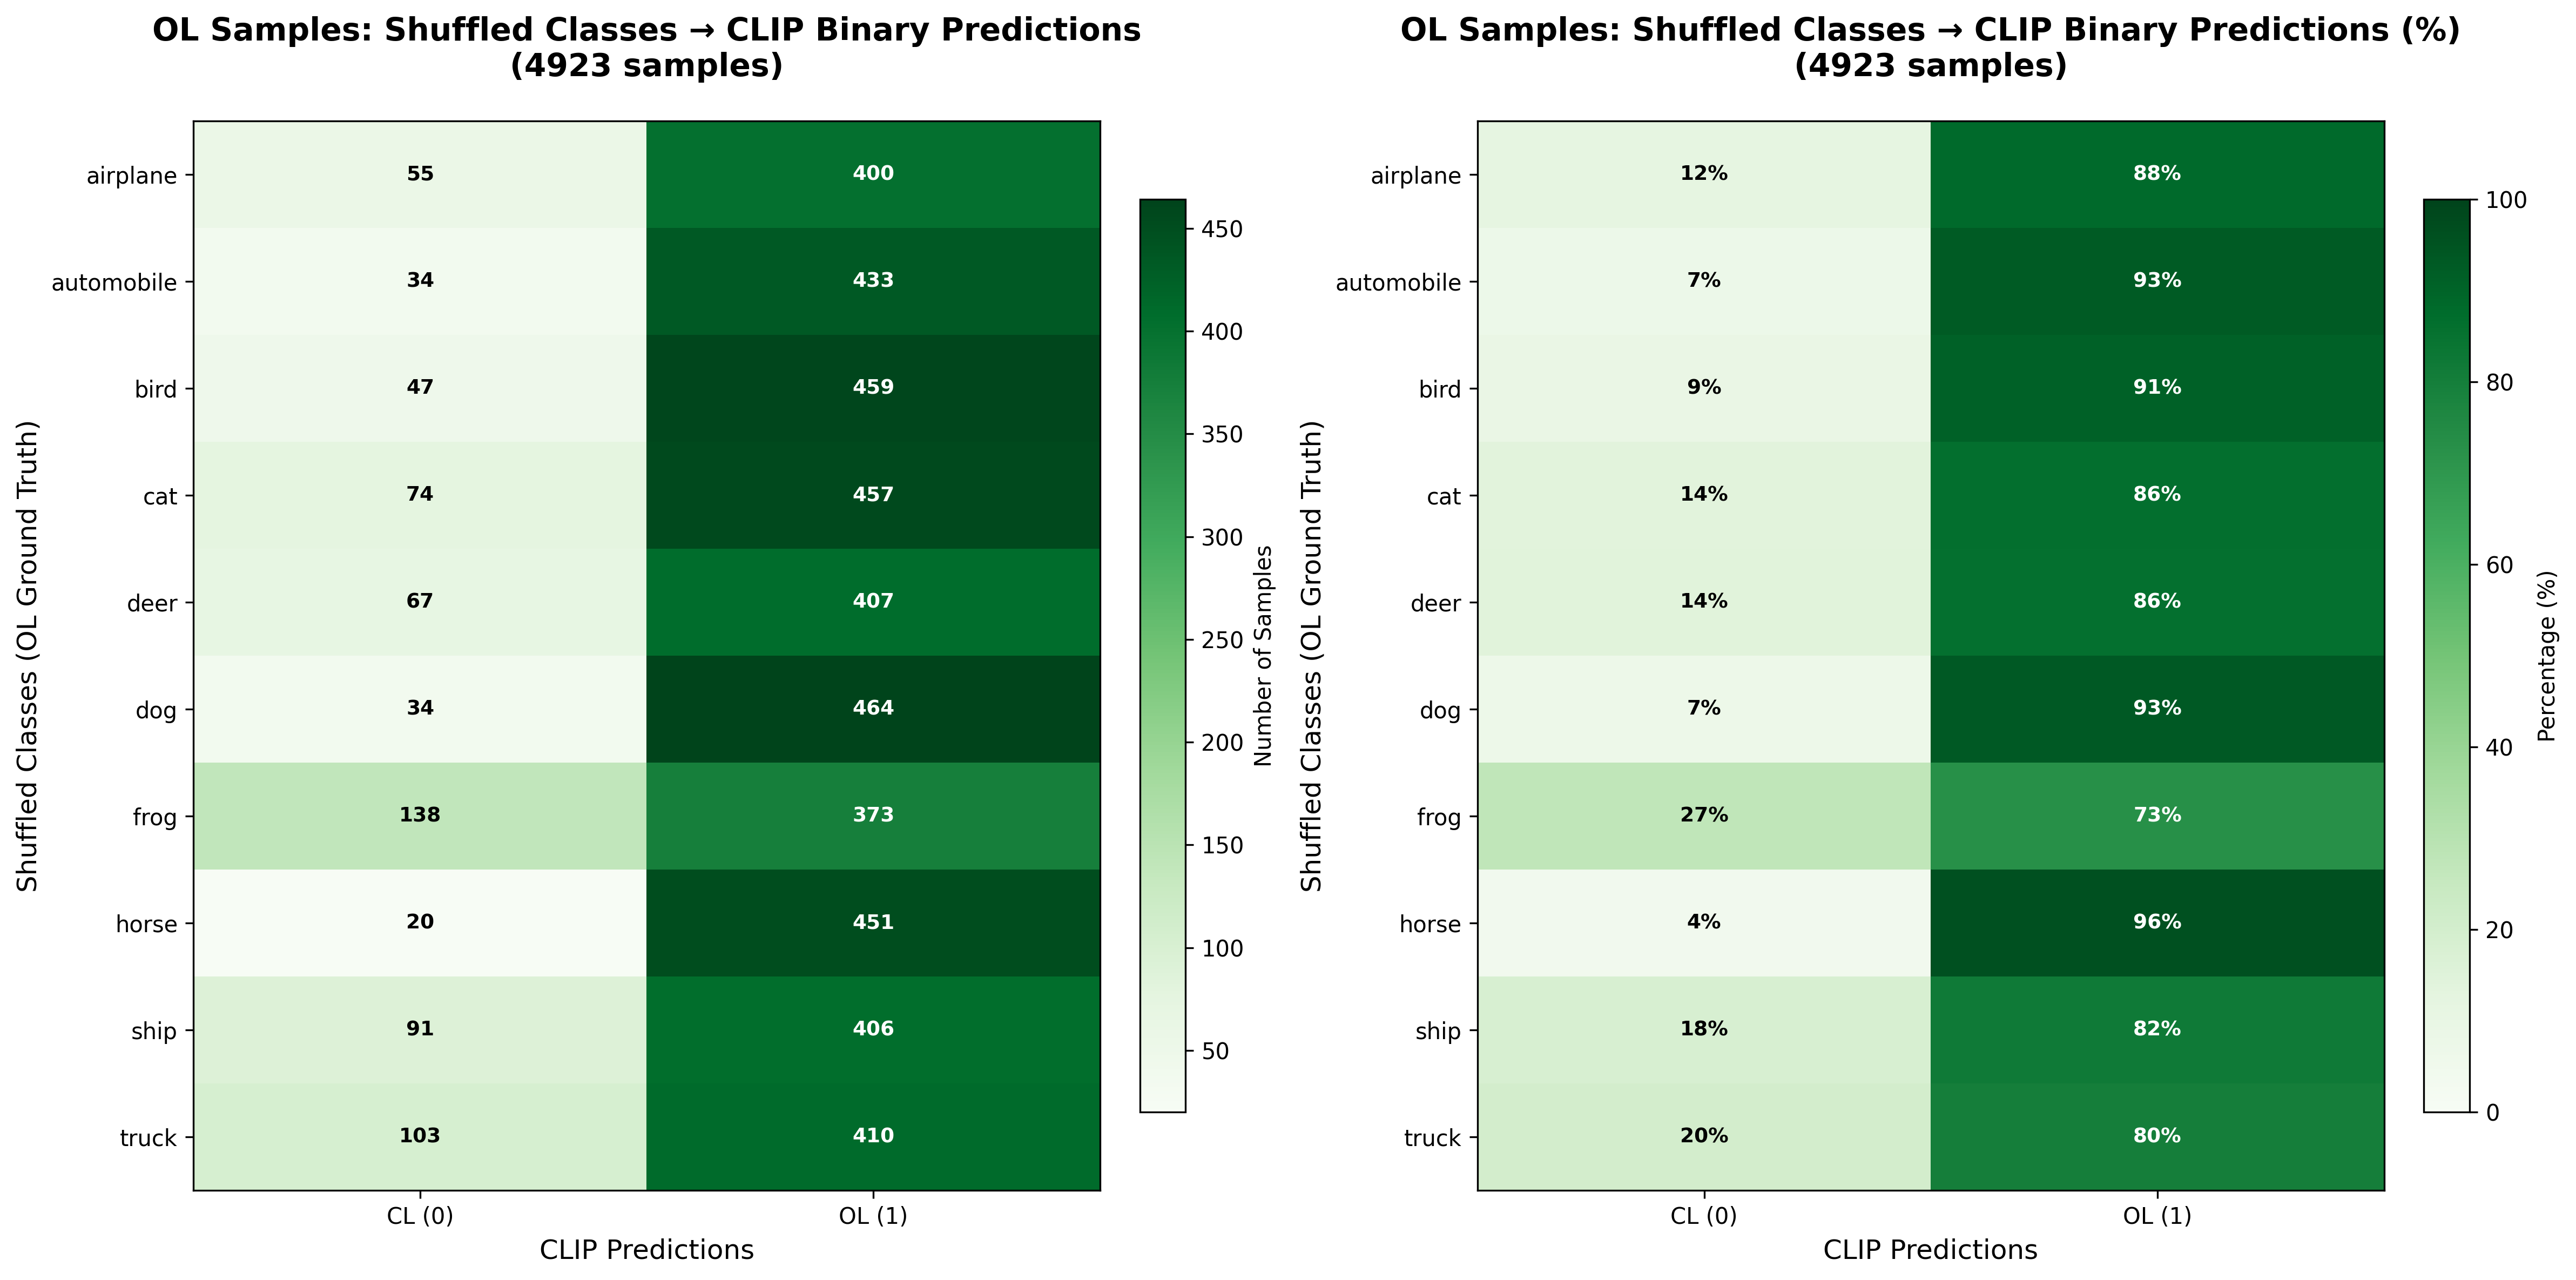


CLASS-WISE TRANSITION ANALYSIS
Sample distribution:
• Total samples: 50,000
• CL samples (incorrect labels): 45,077 (90.2%)
• OL samples (correct labels): 4,923 (9.8%)

Overall accuracy: 94.0%

CLASS-WISE PREDICTION PATTERNS
Class        Total   →CL    →OL    %CL    %OL    CL_Acc  OL_Acc
----------------------------------------------------------------------
airplane     5000    4548   452     91.0%   9.0%   98.9%  87.9%
automobile   5000    4420   580     88.4%  11.6%   96.8%  92.7%
bird         5000    4196   804     83.9%  16.1%   92.3%  90.7%
cat          5000    4244   756     84.9%  15.1%   93.3%  86.1%
deer         5000    4410   590     88.2%  11.8%   96.0%  85.9%
dog          5000    3939   1061    78.8%  21.2%   86.7%  93.2%
frog         5000    4523   477     90.5%   9.5%   97.7%  73.0%
horse        5000    4079   921     81.6%  18.4%   89.6%  95.8%
ship         5000    4560   440     91.2%   8.8%   99.2%  81.7%
truck        5000    4496   504     89.9%  10.1%   97.9%  79.9%

In [37]:
# Simple Transition Analysis using existing preds and batch mapping
print("="*70)
print("TRANSITION ANALYSIS: SHUFFLED LABELS → BINARY CL/OL PREDICTIONS")
print("="*70)

# Use existing data - no need to rerun CLIP
print("Using existing predictions and labels...")

# Get the data we need
shuffled_labels_subset = shuffled_labels_all[:len(preds)]
gts_subset = np.array(gts)[:len(preds)]
preds_array = np.array(preds)
class_names = shuffled_dataset.classes
n_classes = len(class_names)

print(f"Total samples processed: {len(shuffled_labels_subset)}")
print(f"Predictions available: {len(preds_array)}")

# Create transition matrix: Shuffled Class → Binary Prediction (CL=0, OL=1)
# This shows how each shuffled class is predicted by CLIP as CL or OL
class_to_prediction_matrix = np.zeros((n_classes, 2), dtype=int)  # [class, prediction]

for i in range(len(shuffled_labels_subset)):
    shuffled_class = shuffled_labels_subset[i]
    prediction = preds_array[i]  # 0=CL, 1=OL
    class_to_prediction_matrix[shuffled_class, prediction] += 1

# Calculate percentages
class_prediction_percentages = np.zeros_like(class_to_prediction_matrix, dtype=float)
for i in range(n_classes):
    row_total = class_to_prediction_matrix[i].sum()
    if row_total > 0:
        class_prediction_percentages[i] = (class_to_prediction_matrix[i] / row_total) * 100

# Split by ground truth for CL vs OL analysis
cl_mask = (gts_subset == 0)  # Complementary Learning (different labels)
ol_mask = (gts_subset == 1)  # Ordinary Learning (same labels)

# CL samples: shuffled class → binary prediction
cl_shuffled_labels = shuffled_labels_subset[cl_mask]
cl_predictions = preds_array[cl_mask]
cl_class_prediction_matrix = np.zeros((n_classes, 2), dtype=int)

for i in range(len(cl_shuffled_labels)):
    shuffled_class = cl_shuffled_labels[i]
    prediction = cl_predictions[i]
    cl_class_prediction_matrix[shuffled_class, prediction] += 1

# OL samples: shuffled class → binary prediction  
ol_shuffled_labels = shuffled_labels_subset[ol_mask]
ol_predictions = preds_array[ol_mask]
ol_class_prediction_matrix = np.zeros((n_classes, 2), dtype=int)

for i in range(len(ol_shuffled_labels)):
    shuffled_class = ol_shuffled_labels[i]
    prediction = ol_predictions[i]
    ol_class_prediction_matrix[shuffled_class, prediction] += 1

# Calculate percentages for CL and OL
cl_class_percentages = np.zeros_like(cl_class_prediction_matrix, dtype=float)
for i in range(n_classes):
    row_total = cl_class_prediction_matrix[i].sum()
    if row_total > 0:
        cl_class_percentages[i] = (cl_class_prediction_matrix[i] / row_total) * 100

ol_class_percentages = np.zeros_like(ol_class_prediction_matrix, dtype=float)
for i in range(n_classes):
    row_total = ol_class_prediction_matrix[i].sum()
    if row_total > 0:
        ol_class_percentages[i] = (ol_class_prediction_matrix[i] / row_total) * 100

# Set DPI for high-quality plots
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# 1. Overall Class → Binary Prediction Matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Overall absolute counts
im1 = ax1.imshow(class_to_prediction_matrix, cmap='Blues', aspect='auto')
ax1.set_title(f'Overall: Shuffled Classes → CLIP Binary Predictions\n({len(shuffled_labels_subset)} samples)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('CLIP Predictions', fontsize=12)
ax1.set_ylabel('Shuffled Dataset Classes', fontsize=12)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['CL (0)', 'OL (1)'])
ax1.set_yticks(range(n_classes))
ax1.set_yticklabels(class_names)

# Add text annotations (all values)
for i in range(n_classes):
    for j in range(2):
        count = class_to_prediction_matrix[i, j]
        ax1.text(j, i, str(count), ha='center', va='center', 
                fontweight='bold', fontsize=9, 
                color='white' if count > class_to_prediction_matrix.max()/2 else 'black')

cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('Number of Samples', fontsize=10)

# Overall percentages
im2 = ax2.imshow(class_prediction_percentages, cmap='Blues', aspect='auto', vmin=0, vmax=100)
ax2.set_title(f'Overall: Shuffled Classes → CLIP Binary Predictions (%)\n({len(shuffled_labels_subset)} samples)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('CLIP Predictions', fontsize=12)
ax2.set_ylabel('Shuffled Dataset Classes', fontsize=12)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['CL (0)', 'OL (1)'])
ax2.set_yticks(range(n_classes))
ax2.set_yticklabels(class_names)

# Add text annotations (percentages)
for i in range(n_classes):
    for j in range(2):
        pct = class_prediction_percentages[i, j]
        if pct > 0:
            ax2.text(j, i, f'{pct:.0f}%', ha='center', va='center', 
                    fontweight='bold', fontsize=9,
                    color='white' if pct > 50 else 'black')

cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label('Percentage (%)', fontsize=10)

plt.tight_layout()
plt.show()

# 2. CL samples analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

im1 = ax1.imshow(cl_class_prediction_matrix, cmap='Reds', aspect='auto')
ax1.set_title(f'CL Samples: Shuffled Classes → CLIP Binary Predictions\n({len(cl_shuffled_labels)} samples)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('CLIP Predictions', fontsize=12)
ax1.set_ylabel('Shuffled Classes (CL Ground Truth)', fontsize=12)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['CL (0)', 'OL (1)'])
ax1.set_yticks(range(n_classes))
ax1.set_yticklabels(class_names)

for i in range(n_classes):
    for j in range(2):
        count = cl_class_prediction_matrix[i, j]
        if count > 0:
            ax1.text(j, i, str(count), ha='center', va='center', 
                    fontweight='bold', fontsize=9, 
                    color='white' if count > cl_class_prediction_matrix.max()/2 else 'black')

cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('Number of Samples', fontsize=10)

im2 = ax2.imshow(cl_class_percentages, cmap='Reds', aspect='auto', vmin=0, vmax=100)
ax2.set_title(f'CL Samples: Shuffled Classes → CLIP Binary Predictions (%)\n({len(cl_shuffled_labels)} samples)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('CLIP Predictions', fontsize=12)
ax2.set_ylabel('Shuffled Classes (CL Ground Truth)', fontsize=12)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['CL (0)', 'OL (1)'])
ax2.set_yticks(range(n_classes))
ax2.set_yticklabels(class_names)

for i in range(n_classes):
    for j in range(2):
        pct = cl_class_percentages[i, j]
        if pct > 0:
            ax2.text(j, i, f'{pct:.0f}%', ha='center', va='center', 
                    fontweight='bold', fontsize=9,
                    color='white' if pct > 50 else 'black')

cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label('Percentage (%)', fontsize=10)

plt.tight_layout()
plt.show()

# 3. OL samples analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

im1 = ax1.imshow(ol_class_prediction_matrix, cmap='Greens', aspect='auto')
ax1.set_title(f'OL Samples: Shuffled Classes → CLIP Binary Predictions\n({len(ol_shuffled_labels)} samples)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('CLIP Predictions', fontsize=12)
ax1.set_ylabel('Shuffled Classes (OL Ground Truth)', fontsize=12)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['CL (0)', 'OL (1)'])
ax1.set_yticks(range(n_classes))
ax1.set_yticklabels(class_names)

for i in range(n_classes):
    for j in range(2):
        count = ol_class_prediction_matrix[i, j]
        if count > 0:
            ax1.text(j, i, str(count), ha='center', va='center', 
                    fontweight='bold', fontsize=9, 
                    color='white' if count > ol_class_prediction_matrix.max()/2 else 'black')

cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('Number of Samples', fontsize=10)

im2 = ax2.imshow(ol_class_percentages, cmap='Greens', aspect='auto', vmin=0, vmax=100)
ax2.set_title(f'OL Samples: Shuffled Classes → CLIP Binary Predictions (%)\n({len(ol_shuffled_labels)} samples)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('CLIP Predictions', fontsize=12)
ax2.set_ylabel('Shuffled Classes (OL Ground Truth)', fontsize=12)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['CL (0)', 'OL (1)'])
ax2.set_yticks(range(n_classes))
ax2.set_yticklabels(class_names)

for i in range(n_classes):
    for j in range(2):
        pct = ol_class_percentages[i, j]
        if pct > 0:
            ax2.text(j, i, f'{pct:.0f}%', ha='center', va='center', 
                    fontweight='bold', fontsize=9,
                    color='white' if pct > 50 else 'black')

cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label('Percentage (%)', fontsize=10)

plt.tight_layout()
plt.show()

# Analysis and Statistics
print("\n" + "="*80)
print("CLASS-WISE TRANSITION ANALYSIS")
print("="*80)

print(f"Sample distribution:")
print(f"• Total samples: {len(shuffled_labels_subset):,}")
print(f"• CL samples (incorrect labels): {len(cl_shuffled_labels):,} ({len(cl_shuffled_labels)/len(shuffled_labels_subset):.1%})")
print(f"• OL samples (correct labels): {len(ol_shuffled_labels):,} ({len(ol_shuffled_labels)/len(shuffled_labels_subset):.1%})")

print(f"\nOverall accuracy: {(preds_array == gts_subset).sum() / len(preds_array):.1%}")

print(f"\n" + "="*60)
print("CLASS-WISE PREDICTION PATTERNS")
print("="*60)
print(f"{'Class':<12} {'Total':<7} {'→CL':<6} {'→OL':<6} {'%CL':<6} {'%OL':<6} {'CL_Acc':<7} {'OL_Acc'}")
print("-" * 70)

for i, class_name in enumerate(class_names):
    total_samples = class_to_prediction_matrix[i].sum()
    cl_preds = class_to_prediction_matrix[i, 0]
    ol_preds = class_to_prediction_matrix[i, 1]
    
    if total_samples > 0:
        cl_pct = cl_preds / total_samples * 100
        ol_pct = ol_preds / total_samples * 100
        
        # Accuracy for this class in CL and OL groups
        cl_total = cl_class_prediction_matrix[i].sum()
        ol_total = ol_class_prediction_matrix[i].sum()
        
        cl_correct = cl_class_prediction_matrix[i, 0]  # CL samples predicted as CL
        ol_correct = ol_class_prediction_matrix[i, 1]  # OL samples predicted as OL
        
        cl_acc = (cl_correct / cl_total * 100) if cl_total > 0 else 0
        ol_acc = (ol_correct / ol_total * 100) if ol_total > 0 else 0
        
        print(f"{class_name:<12} {total_samples:<7} {cl_preds:<6} {ol_preds:<6} "
              f"{cl_pct:>5.1f}% {ol_pct:>5.1f}% {cl_acc:>6.1f}% {ol_acc:>5.1f}%")

# Most CL-prone and OL-prone classes
cl_percentages_per_class = []
ol_percentages_per_class = []

for i in range(n_classes):
    total = class_to_prediction_matrix[i].sum()
    if total > 0:
        cl_pct = class_to_prediction_matrix[i, 0] / total * 100
        ol_pct = class_to_prediction_matrix[i, 1] / total * 100
        cl_percentages_per_class.append((i, cl_pct))
        ol_percentages_per_class.append((i, ol_pct))

cl_percentages_per_class.sort(key=lambda x: x[1], reverse=True)
ol_percentages_per_class.sort(key=lambda x: x[1], reverse=True)

print(f"\n" + "="*50)
print("TOP CLASSES BY PREDICTION TENDENCY")
print("="*50)

print("Most CL-prone classes (predicted as different):")
for i, (class_idx, pct) in enumerate(cl_percentages_per_class[:5]):
    print(f"{i+1}. {class_names[class_idx]:<12}: {pct:5.1f}% → CL")

print("\nMost OL-prone classes (predicted as same):")
for i, (class_idx, pct) in enumerate(ol_percentages_per_class[:5]):
    print(f"{i+1}. {class_names[class_idx]:<12}: {pct:5.1f}% → OL")

# Reset DPI
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

print(f"\nInterpretation:")
print("- Each matrix shows how CLIP predicts CL (0) vs OL (1) for each shuffled class")
print("- Blue: Overall patterns across all samples")
print("- Red: CL samples (images with incorrect shuffled labels)")
print("- Green: OL samples (images with correct shuffled labels)")  
print("- This reveals which classes CLIP finds easier/harder to distinguish")
print("- Ideally, CL samples should be predicted as CL (0) and OL as OL (1)")